# Importing all the libraries -


In [464]:
from nltk.corpus import stopwords
from nltk.stem.porter import*
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import pickle
from sklearn import tree, metrics, model_selection , preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,BaggingRegressor,RandomForestRegressor
from xgboost.sklearn import XGBClassifier
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence
%matplotlib inline

# Getting data from source

In [465]:
df=pd.read_csv('train.tsv',sep='\t')

In [466]:
df.head()

PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

In [467]:
def drop_duplicates(dfs):
    dfs.drop_duplicates(subset='SentenceId',keep='first',inplace=True)
    return dfs

In [468]:
df=drop_duplicates(df)

In [469]:
df['SentenceId'].duplicated().any()

False

In [470]:
df.head()

PhraseId  SentenceId                                             Phrase  \
0           1           1  A series of escapades demonstrating the adage ...   
63         64           2  This quiet , introspective and entertaining in...   
81         82           3  Even fans of Ismail Merchant 's work , I suspe...   
116       117           4  A positively thrilling combination of ethnogra...   
156       157           5  Aggressive self-glorification and a manipulati...   

     Sentiment  
0            1  
63           4  
81           1  
116          3  
156          1

# Analysing data-

In [471]:
df.isnull().any()

PhraseId      False
SentenceId    False
Phrase        False
Sentiment     False
dtype: bool

# There is no NULL values

# Check the range of values in label 

In [472]:
df['Sentiment'].unique()

array([1, 4, 3, 2, 0], dtype=int64)

# Remove special Charcters/stop words

In [473]:
df['Sentiment'].max()

4

In [474]:
stop=stopwords.words('english')
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [475]:

df['Phrase'].shape

(8529,)

In [476]:
punc=string.punctuation
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [477]:
def remove_stopword(rawdata):
    dfcnl=rawdata.apply(lambda x:' '.join([item for item in x.split() if item  not in stop]))
    dfcnl=dfcnl.apply(lambda x: ' '.join([wrd for wrd in x.split() if wrd not in punc]))
    return dfcnl

In [478]:
dfcl=remove_stopword(df['Phrase'])


In [479]:
dfcl[:10]

0      A series escapades demonstrating adage good go...
63     This quiet introspective entertaining independ...
81     Even fans Ismail Merchant 's work I suspect wo...
116    A positively thrilling combination ethnography...
156    Aggressive self-glorification manipulative whi...
166    A comedy-drama nearly epic proportions rooted ...
198          Narratively Trouble Every Day plodding mess
213    The Importance Being Earnest thick wit plays l...
247                                   But n't leave much
259                                You could hate reason
Name: Phrase, dtype: object

# Reomve short words

In [480]:
def rem_shortword(textdata):
    filtdata=textdata.apply(lambda x: ' '.join([wd for wd in x.split() if len(wd)>3]))
    return filtdata

In [481]:
dfflt= rem_shortword(dfcl)
dfflt[:10]

0      series escapades demonstrating adage good goos...
63     This quiet introspective entertaining independ...
81     Even fans Ismail Merchant work suspect would h...
116    positively thrilling combination ethnography i...
156    Aggressive self-glorification manipulative whi...
166    comedy-drama nearly epic proportions rooted si...
198              Narratively Trouble Every plodding mess
213    Importance Being Earnest thick plays like read...
247                                           leave much
259                                    could hate reason
Name: Phrase, dtype: object

After removing the short words we find a number of rows with empty values, lets remove that

In [482]:
def replace_empty_rows(dfr):
    dfr.replace('',np.nan,inplace=True)
    return dfr

In [483]:
dfflt=replace_empty_rows(dfflt)

In [484]:
dfflt[:10]

0      series escapades demonstrating adage good goos...
63     This quiet introspective entertaining independ...
81     Even fans Ismail Merchant work suspect would h...
116    positively thrilling combination ethnography i...
156    Aggressive self-glorification manipulative whi...
166    comedy-drama nearly epic proportions rooted si...
198              Narratively Trouble Every plodding mess
213    Importance Being Earnest thick plays like read...
247                                           leave much
259                                    could hate reason
Name: Phrase, dtype: object

In [485]:
def drop_na(dfrs):
    dfrs.dropna(inplace=True)
    return dfrs
dfflt=drop_na(dfflt)

In [486]:
def create_wordtokens(sent):
    word_tokens=sent.apply(lambda x: x.split())
    return word_tokens

In [487]:
# Get the token to process it from stemmer

In [488]:
rev_tokens=create_wordtokens(dfflt)
rev_tokens[:10]

0      [series, escapades, demonstrating, adage, good...
63     [This, quiet, introspective, entertaining, ind...
81     [Even, fans, Ismail, Merchant, work, suspect, ...
116    [positively, thrilling, combination, ethnograp...
156    [Aggressive, self-glorification, manipulative,...
166    [comedy-drama, nearly, epic, proportions, root...
198        [Narratively, Trouble, Every, plodding, mess]
213    [Importance, Being, Earnest, thick, plays, lik...
247                                        [leave, much]
259                                [could, hate, reason]
Name: Phrase, dtype: object

In [489]:
# Perform stemming and lemmatization to check for better option

In [490]:
def stem_words(sent): 
    tokens= str(sent).split()
    stemmer=PorterStemmer()
    stemed_dt= [stemmer.stem(token) for token in tokens] 
    stemed_dt=' '.join(stemed_dt)
    return stemed_dt

In [491]:
def lem_words(sents):
    tokens=str(sents).split()
    lemmatizer=WordNetLemmatizer()
    lem_word=[lemmatizer.lemmatize(token) for token in  tokens]
    lem_word=' '.join(lem_word)
    return lem_word

In [492]:
df['Filt_revstm']=dfflt.apply(stem_words)

In [493]:
df['Filt_revlem']=dfflt.apply(lem_words)

In [494]:
df.isnull().any()

PhraseId       False
SentenceId     False
Phrase         False
Sentiment      False
Filt_revstm     True
Filt_revlem     True
dtype: bool

In [495]:
df=drop_na(df)

In [496]:
df.head()

PhraseId  SentenceId                                             Phrase  \
0           1           1  A series of escapades demonstrating the adage ...   
63         64           2  This quiet , introspective and entertaining in...   
81         82           3  Even fans of Ismail Merchant 's work , I suspe...   
116       117           4  A positively thrilling combination of ethnogra...   
156       157           5  Aggressive self-glorification and a manipulati...   

     Sentiment                                        Filt_revstm  \
0            1  seri escapad demonstr adag good goos also good...   
63           4  thi quiet introspect entertain independ worth ...   
81           1  even fan ismail merchant work suspect would ha...   
116          3  posit thrill combin ethnographi intrigu betray...   
156          1              aggress self-glorif manipul whitewash   

                                           Filt_revlem  
0    series escapade demonstrating adage good goose...  
63   This quiet introspective entertaining independ...  
81   Even fan Ismail Merchant work suspect would ha...  
116  positively thrilling combination ethnography i...  
156  Aggressive self-glorification manipulative whi...

# See which all words are there in the reviews having sentment between 0 to 1 in train data

In [497]:
words_1_0=' '.join([wr for wr in df['Filt_revstm'][df['Sentiment']==0 ]])

In [498]:
def get_words_range(clmwrd,clmsent,int_val,fin_val):
    dfwrds=pd.DataFrame()
    dfwrds['wrds']=clmwrd
    dfwrds['sent']=clmsent
    retwords=''
    for i,rows in dfwrds.iterrows():
        if fin_val>int_val:
            if dfwrds['sent'][i]>= int_val and dfwrds['sent'][i]<=fin_val:
                retwords=retwords+''.join(dfwrds['wrds'][i])
        elif fin_val==int_val:
             if dfwrds['sent'][i]== int_val:
                retwords=retwords+''.join(dfwrds['wrds'][i])
        elif int_val>fin_val:
            if dfwrds['sent'][i]>= int_val:
                retwords=retwords+''.join(dfwrds['wrds'][i])
    return retwords

In [499]:
wrds1=get_words_range(df['Filt_revstm'],df['Sentiment'],0,1)

In [500]:
wrds2=get_words_range(df['Filt_revlem'],df['Sentiment'],0,1)

In [501]:
wrds3=get_words_range(df['Filt_revstm'],df['Sentiment'],2,3)

In [502]:
wrds4=get_words_range(df['Filt_revlem'],df['Sentiment'],2,3)

In [503]:
wrds5=get_words_range(df['Filt_revstm'],df['Sentiment'],4,0)

In [504]:
wrds6=get_words_range(df['Filt_revlem'],df['Sentiment'],4,0)

In [505]:
def get_wordcloud(input_words):
    wordcloud=WordCloud(width=1200,height=800,random_state=42,max_font_size=110).generate(input_words)
    plt.figure(figsize=(30,20))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

# Words for sentiment range between 0 to 1

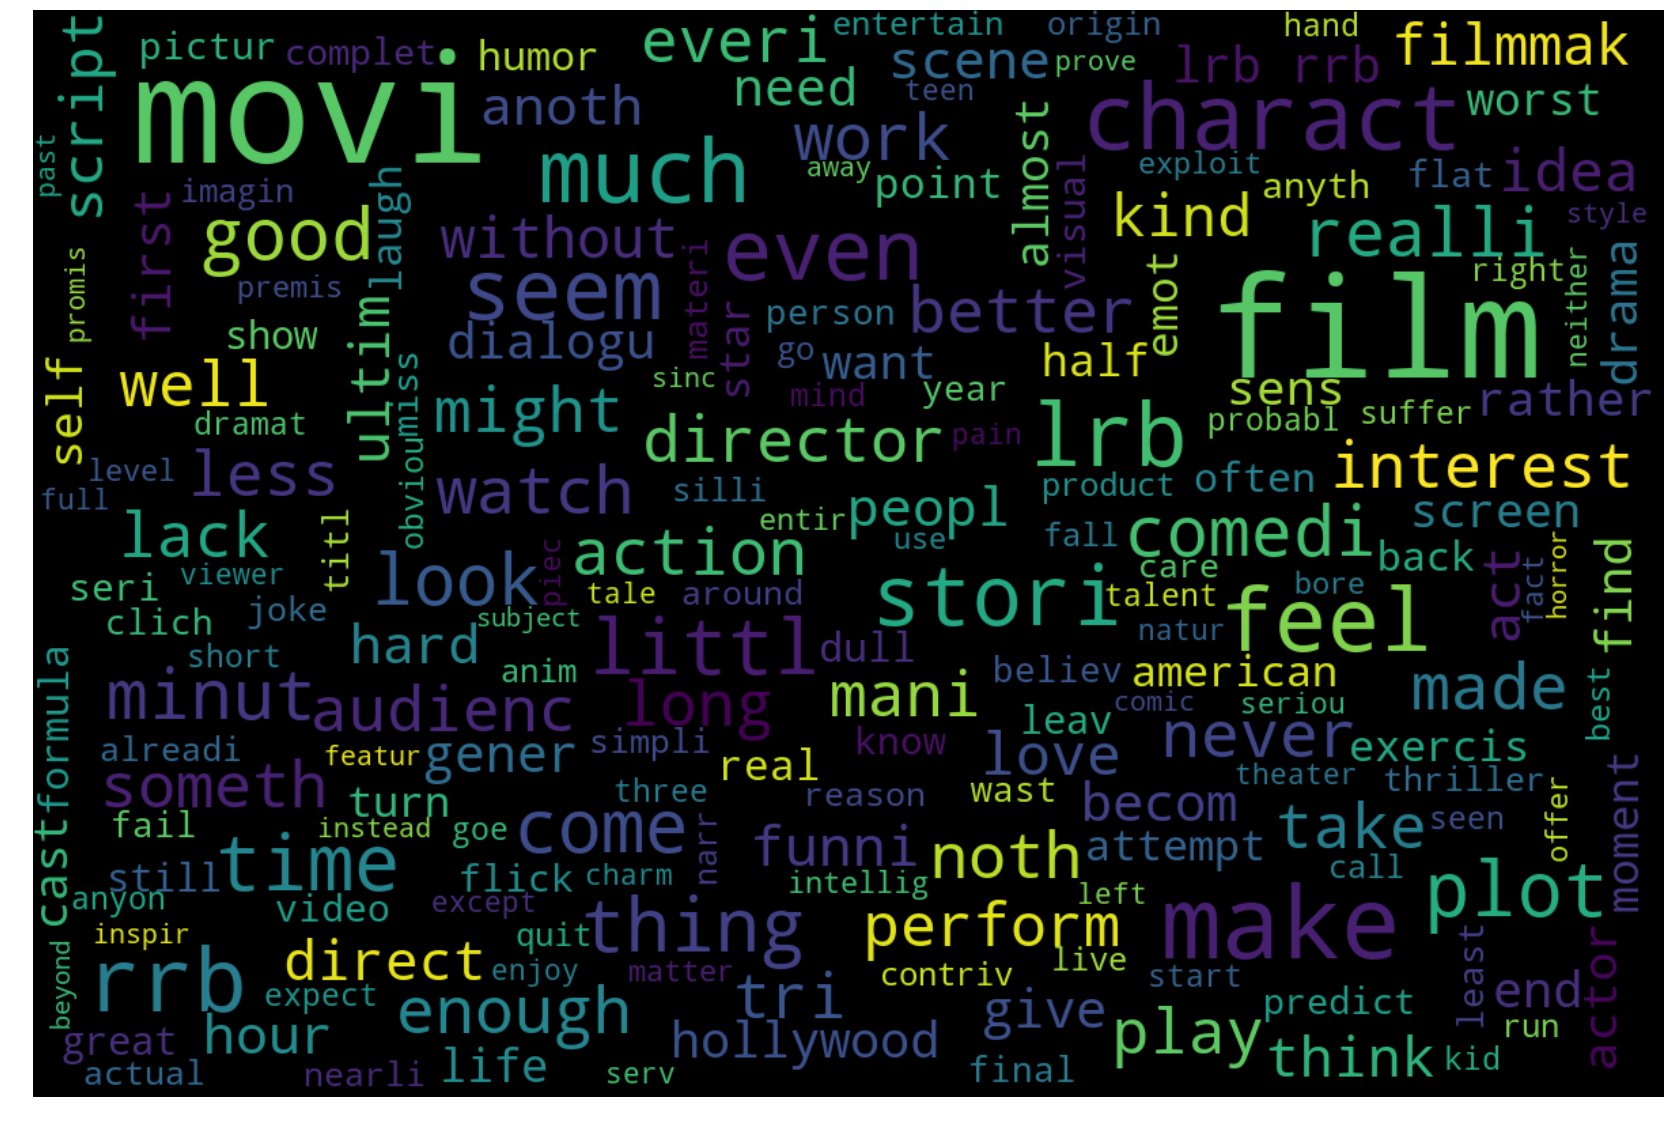

In [506]:
get_wordcloud(wrds1)

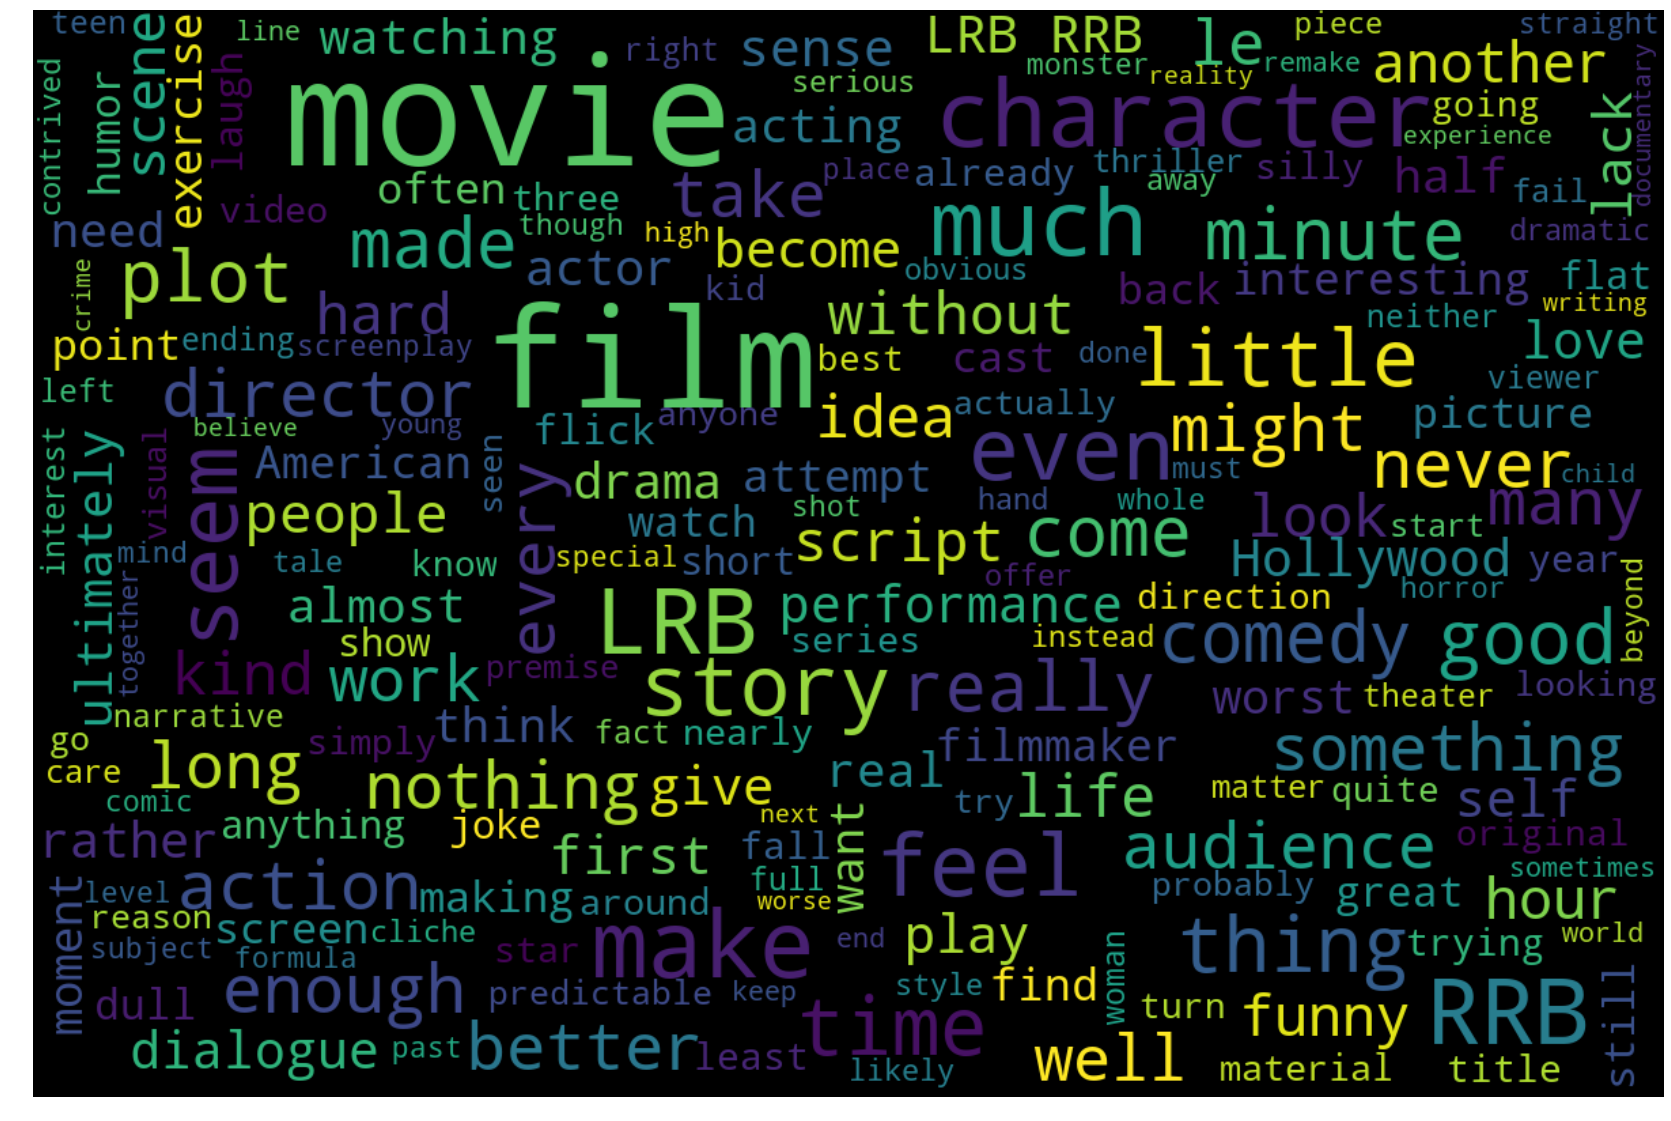

In [507]:
get_wordcloud(wrds2)

# Words for sentiment range between 2 to 3

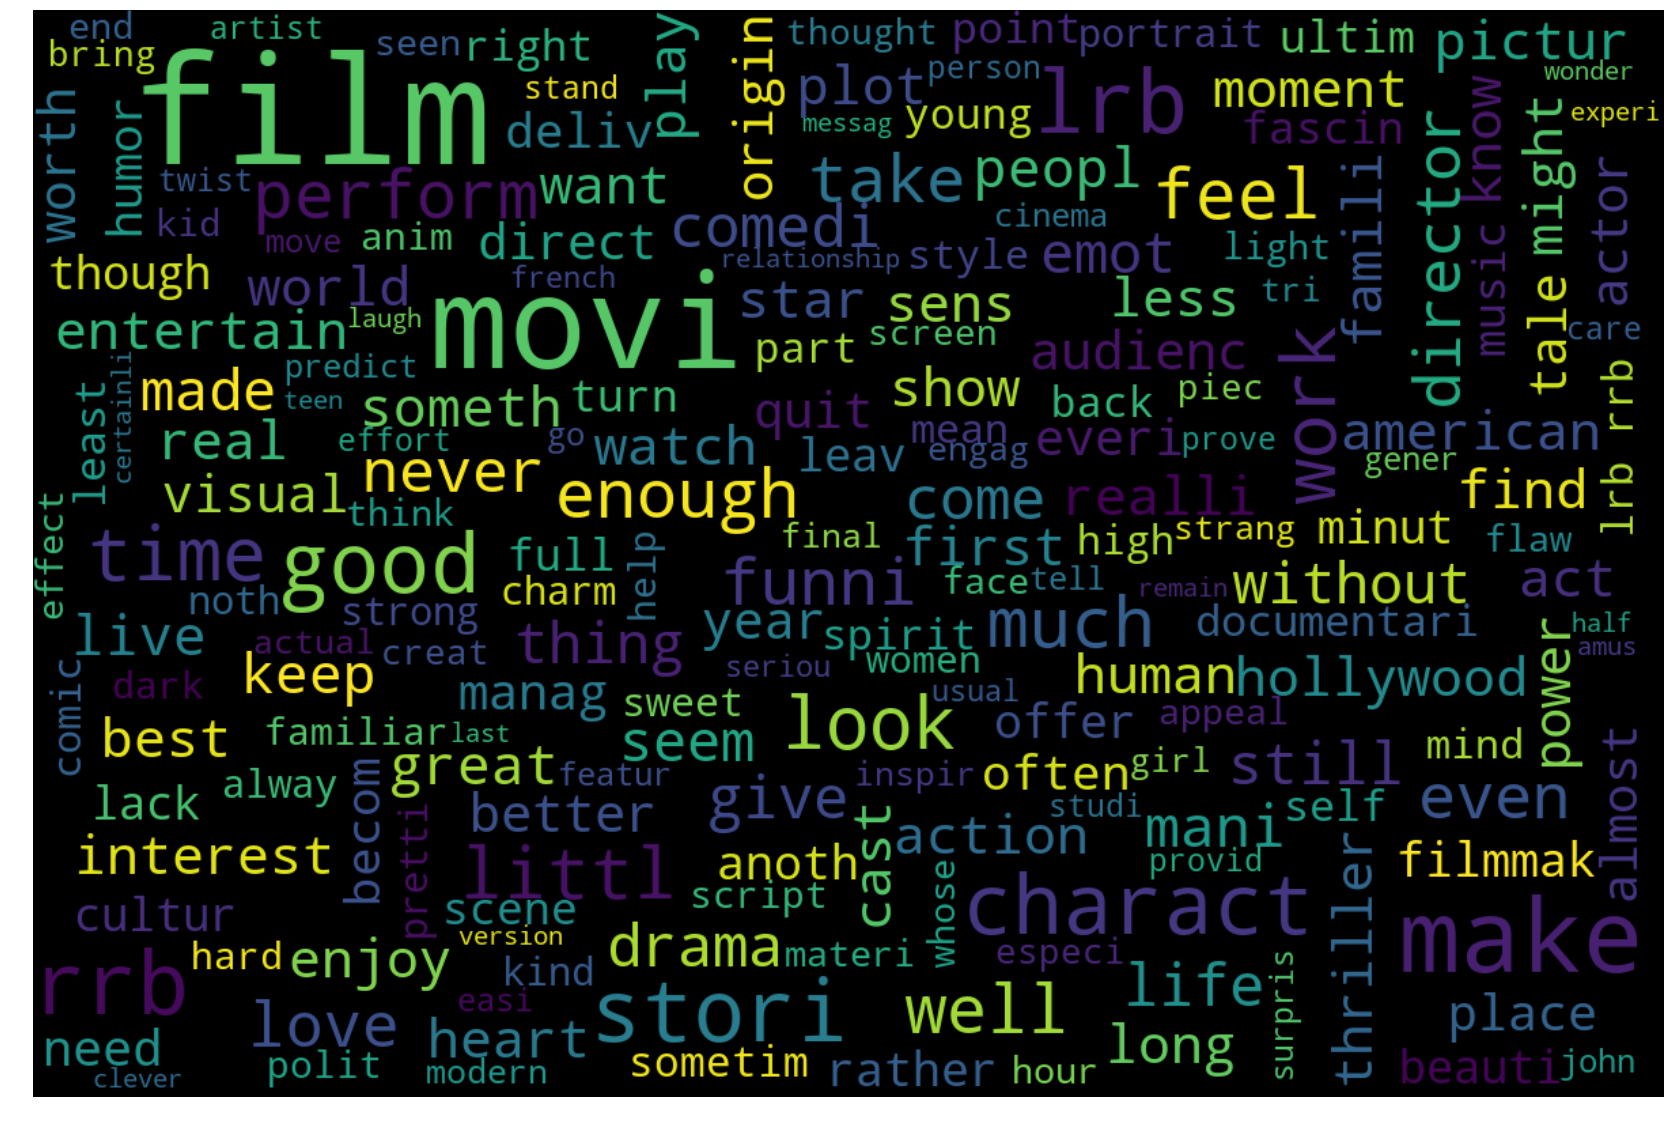

In [508]:
get_wordcloud(wrds3)

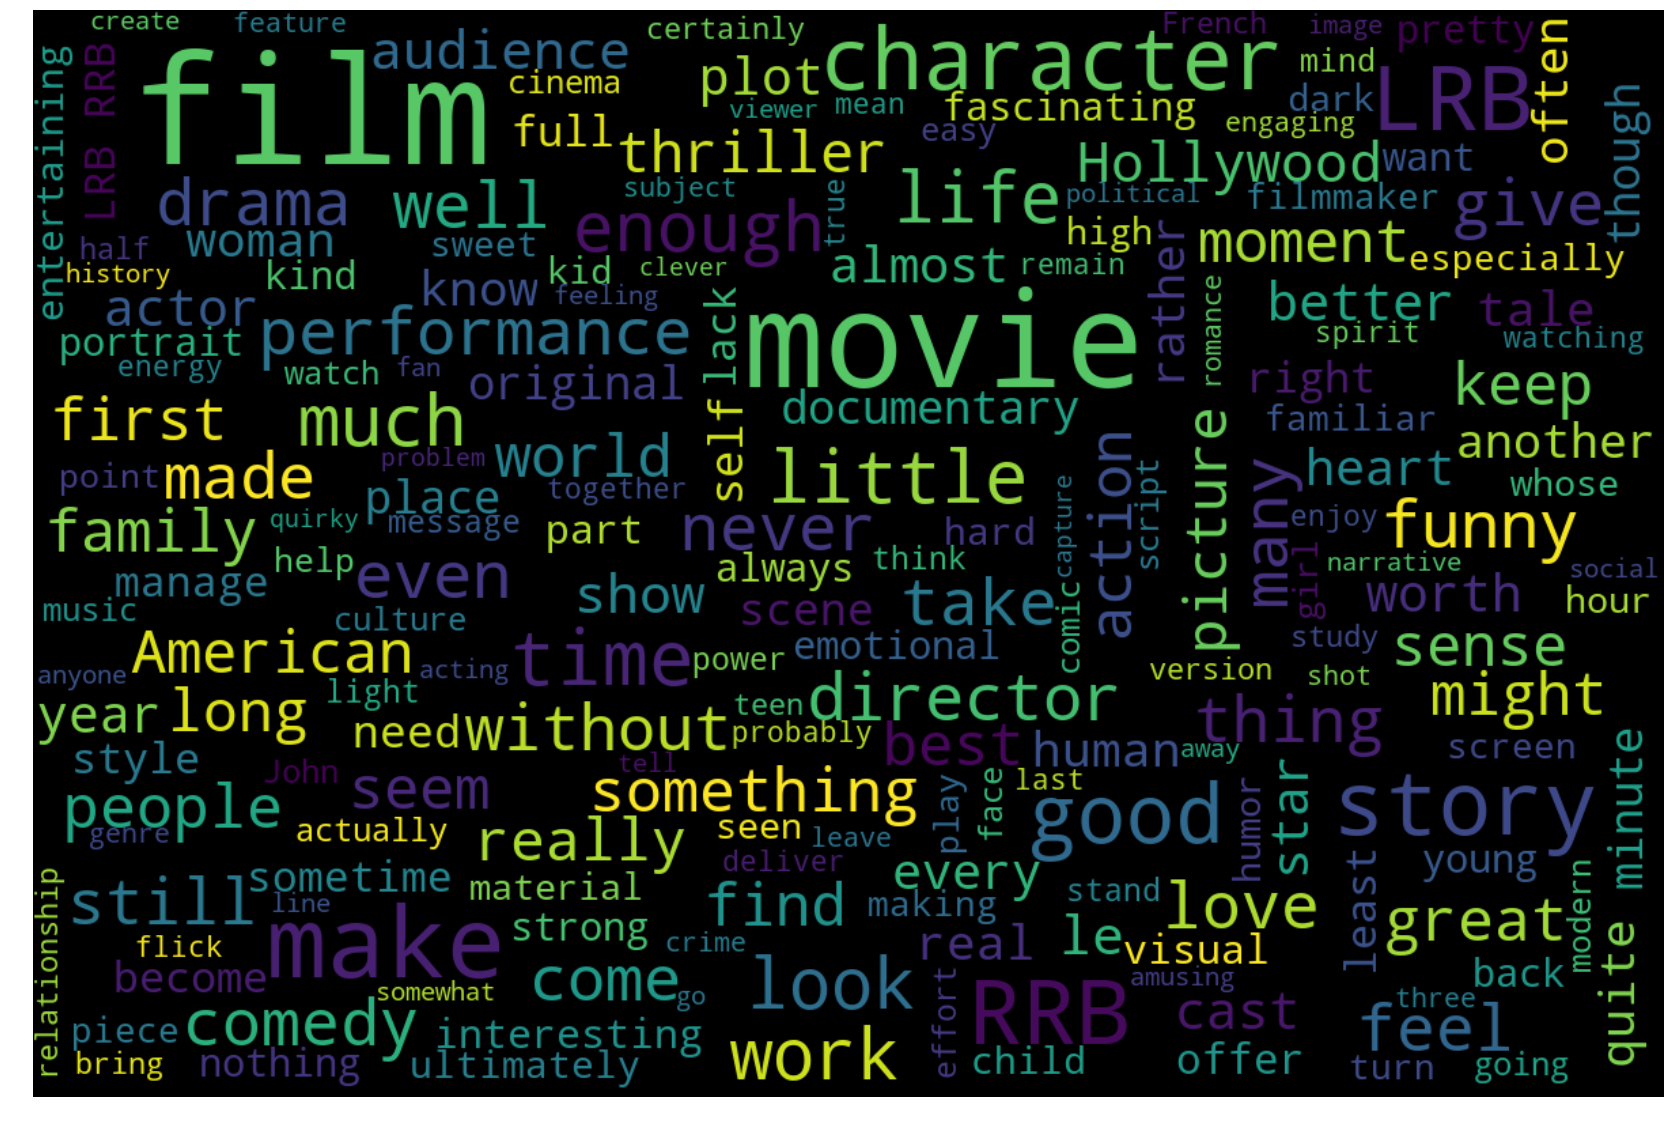

In [509]:
get_wordcloud(wrds4)

# Words for sentiment value equel to or more than 4

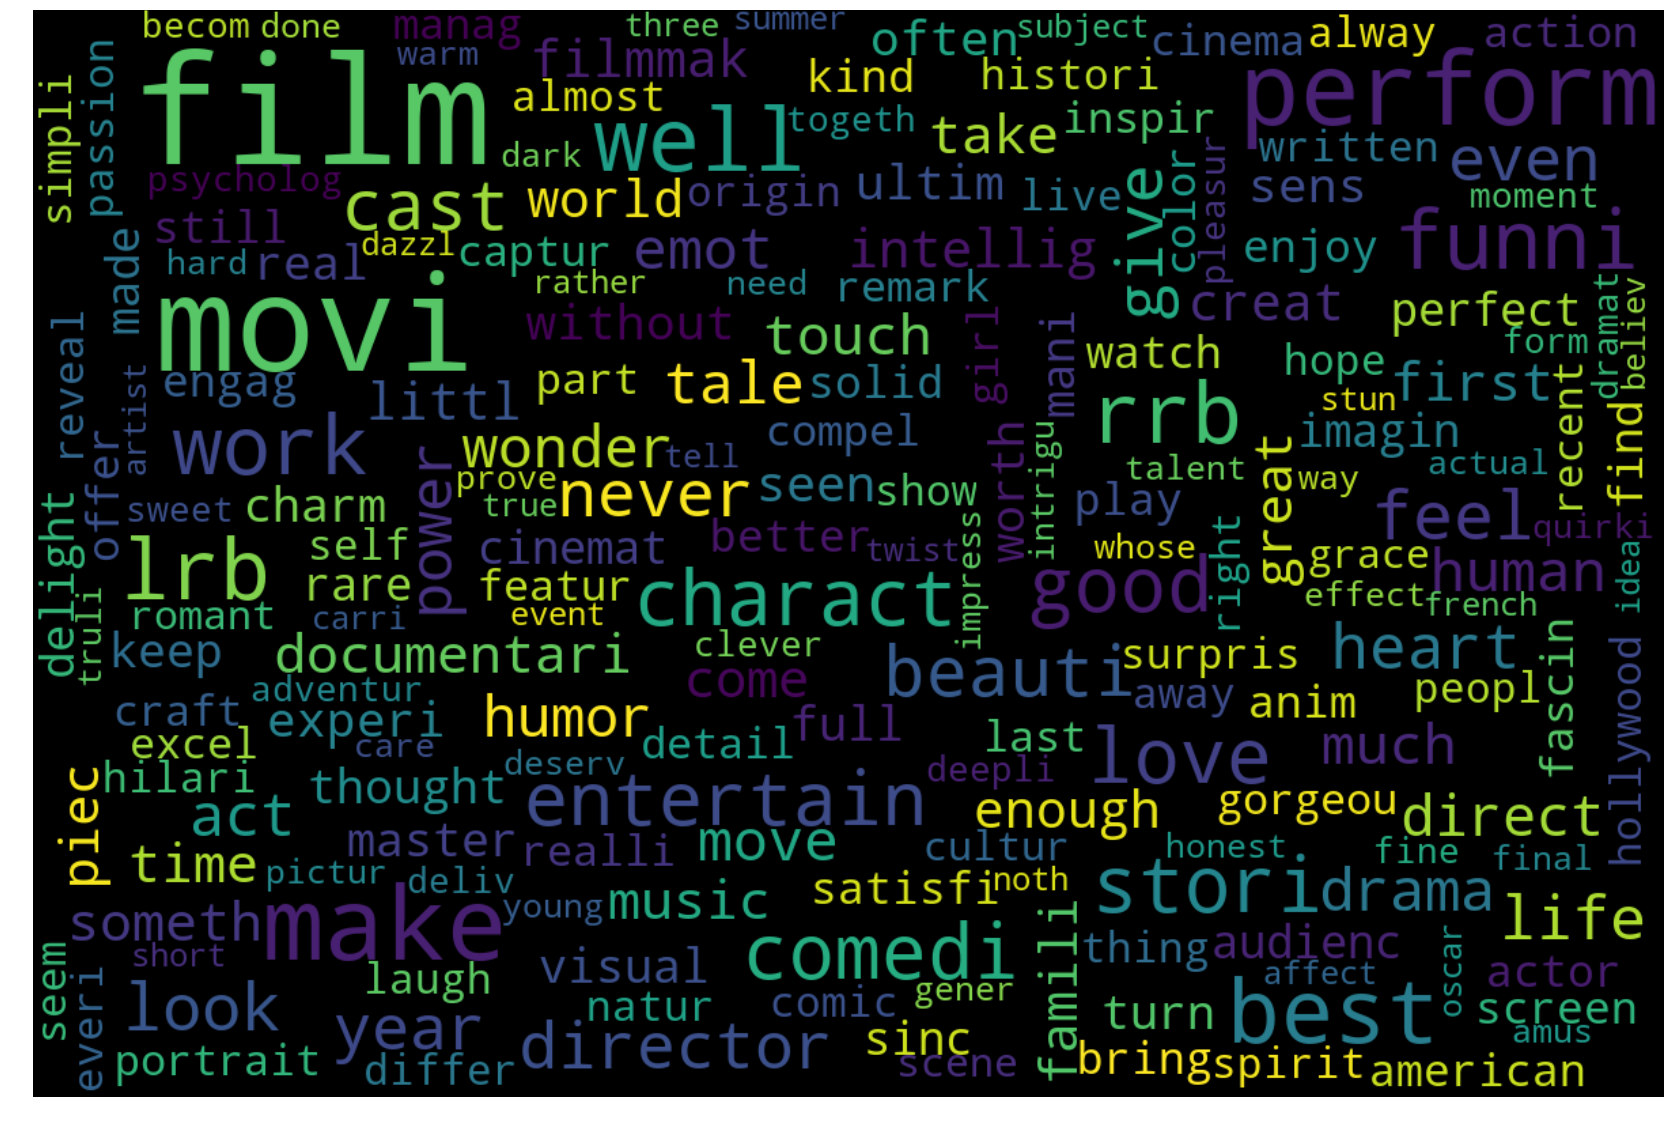

In [510]:
get_wordcloud(wrds5)

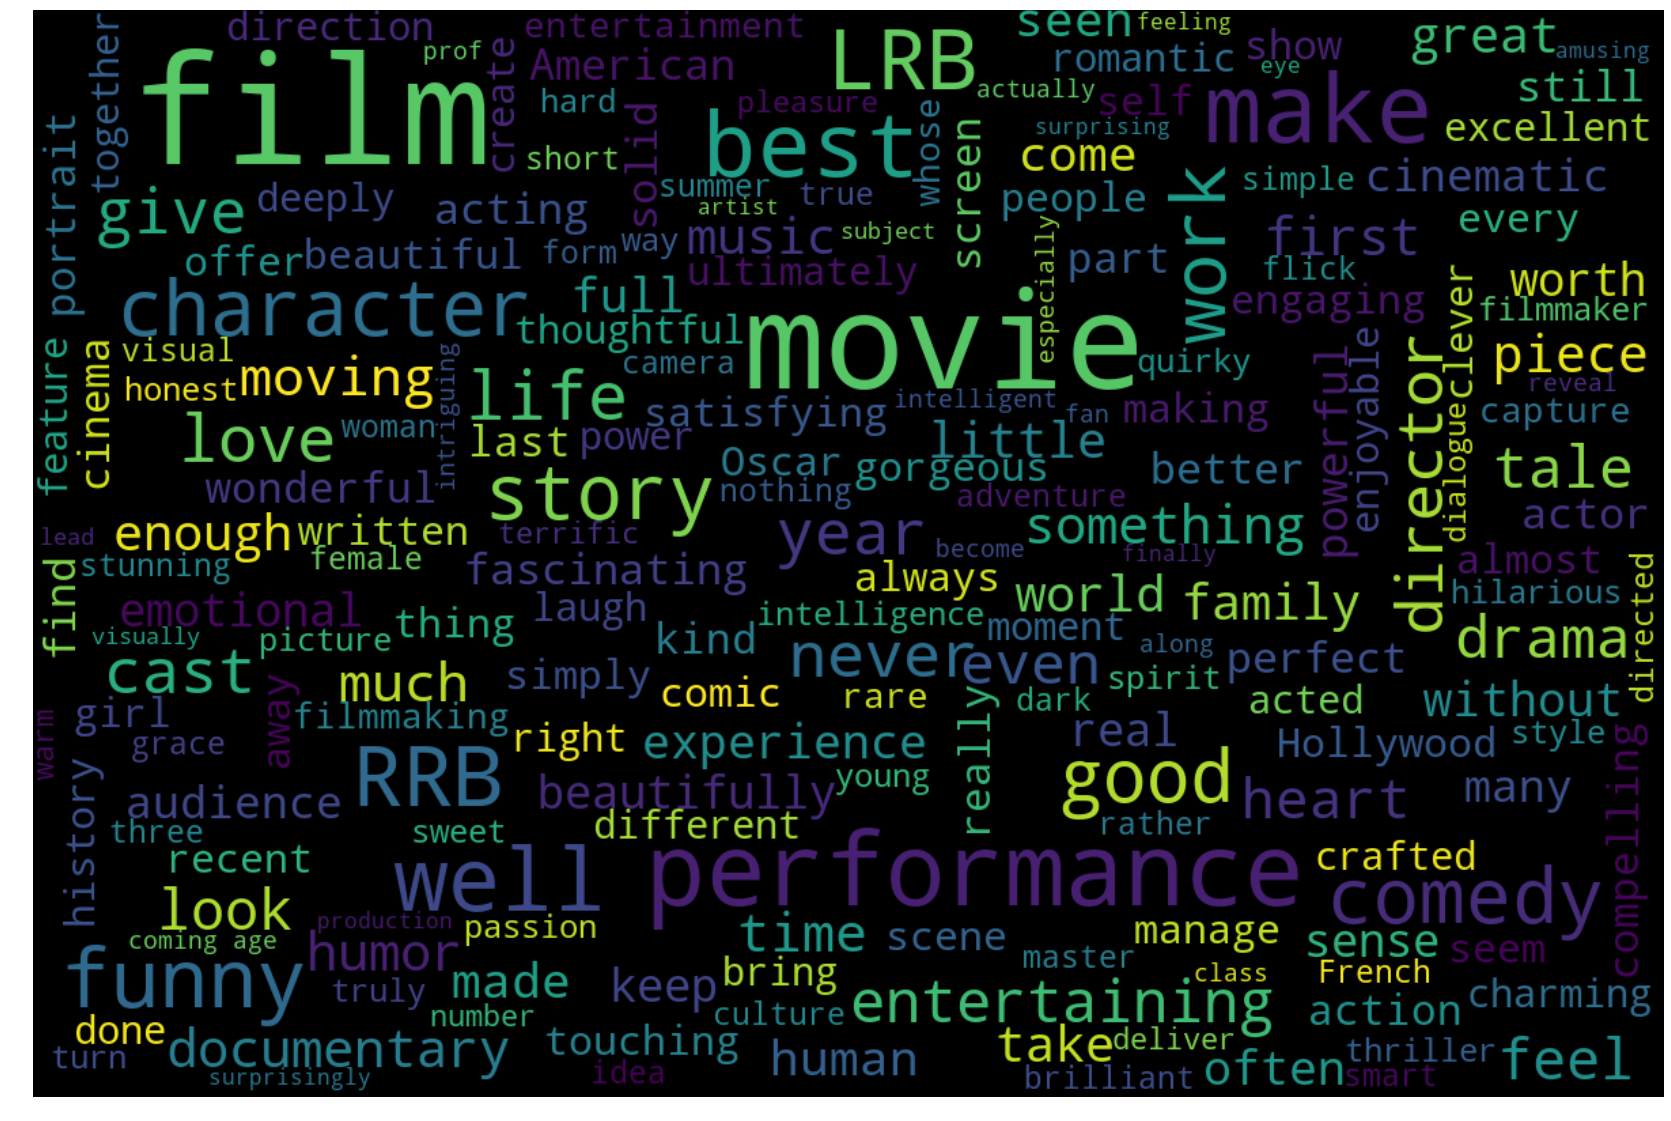

In [511]:
get_wordcloud(wrds6)

Seeing above wordclouds we can say the movie with rating of 4 or more are having more numbers of words like Goo,well,trreific etc

In [512]:
import seaborn as sns

In [513]:
def get_freq_dist(sentences):
    wrds=[]
    for word in sentences.split():
        wrds.append(word)
    fd = nltk.FreqDist(wrds)
    plt.figure(figsize=(18,15))
    fd.plot(40,cumulative=False)

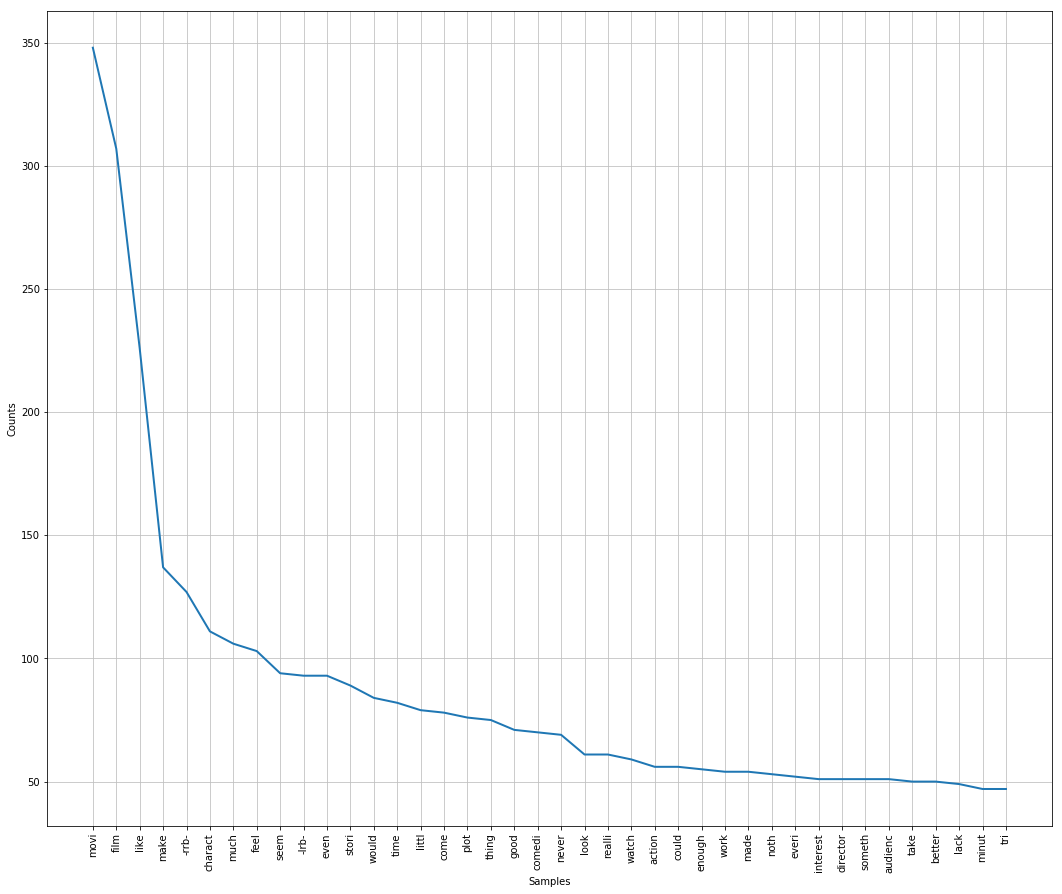

In [514]:
get_freq_dist(wrds1)

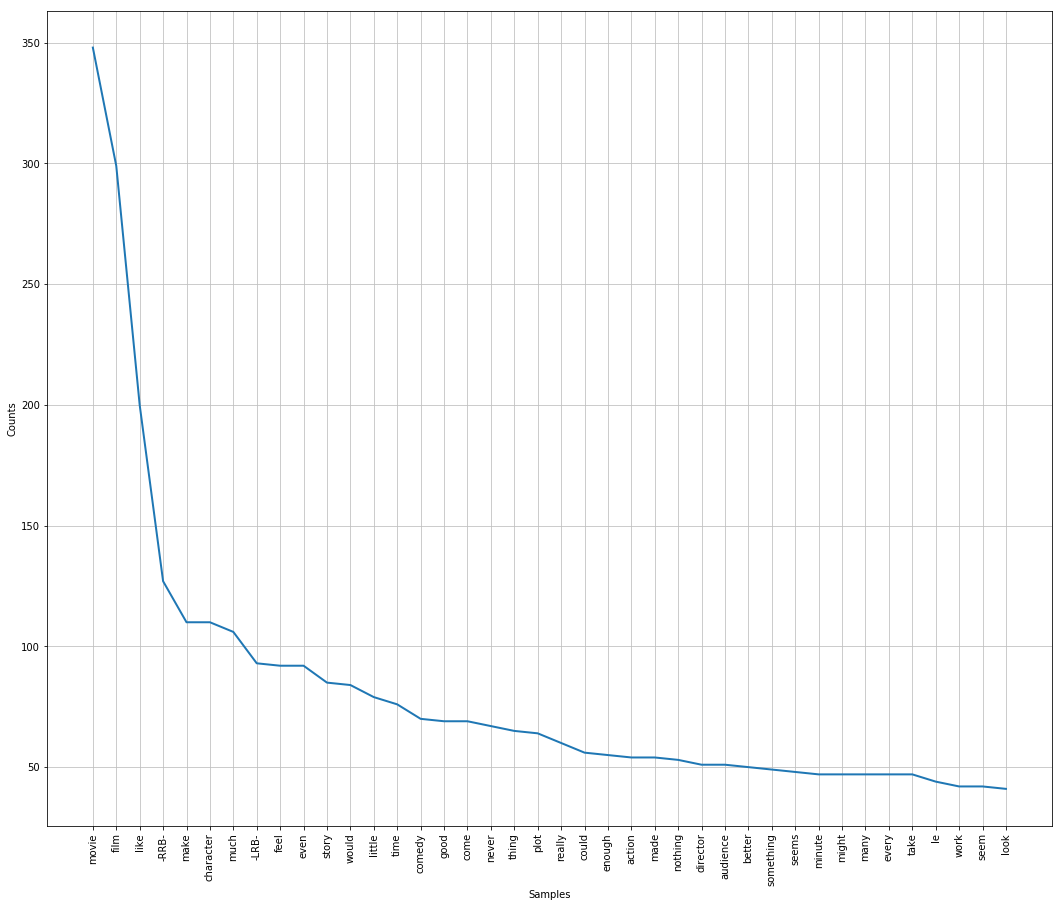

In [515]:
get_freq_dist(wrds2)

Above two graphs are of data having rating from 0 to 1 for stemmed and lemmatized words respectively and here we can see that the mot prominent word is movie which obvious as data is of movie reviews , and if we see top 10 dominent words then we find that there is no words like good,best excellent, and so the reviewes are is some how related to rating or sentiment , but it can also said that these are not too much accurate .

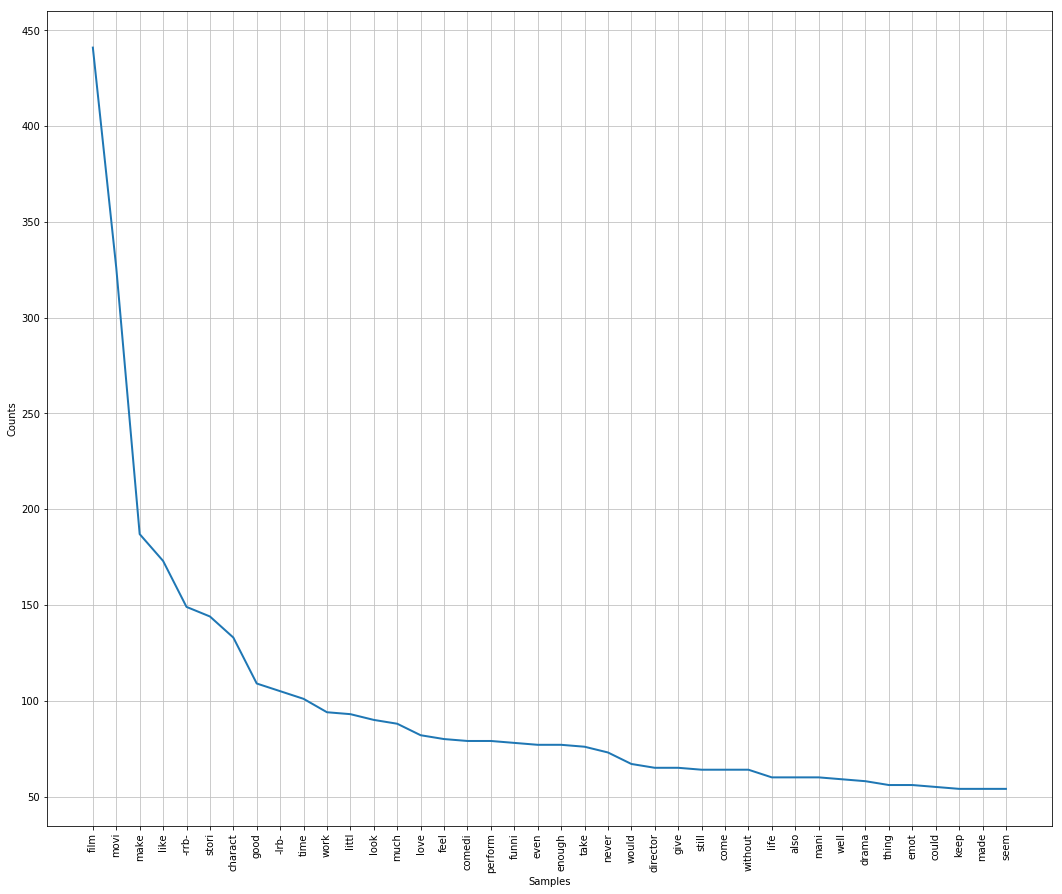

In [516]:
get_freq_dist(wrds3)

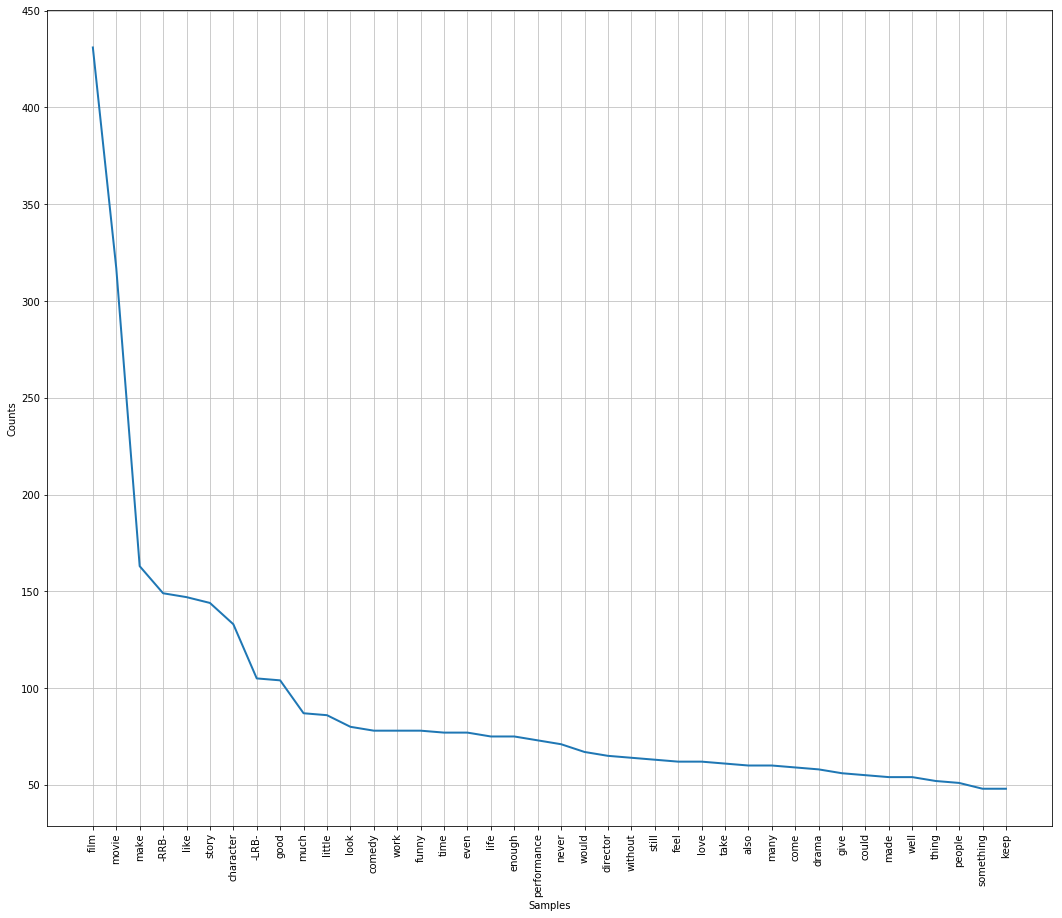

In [517]:
get_freq_dist(wrds4)

The above to graphs are of reviews with sentimnet from 2 to 3 and here we can see that the wor good is having some higher presence than for rating of 0 and 1. So here also reviewes are resembling with ratings.

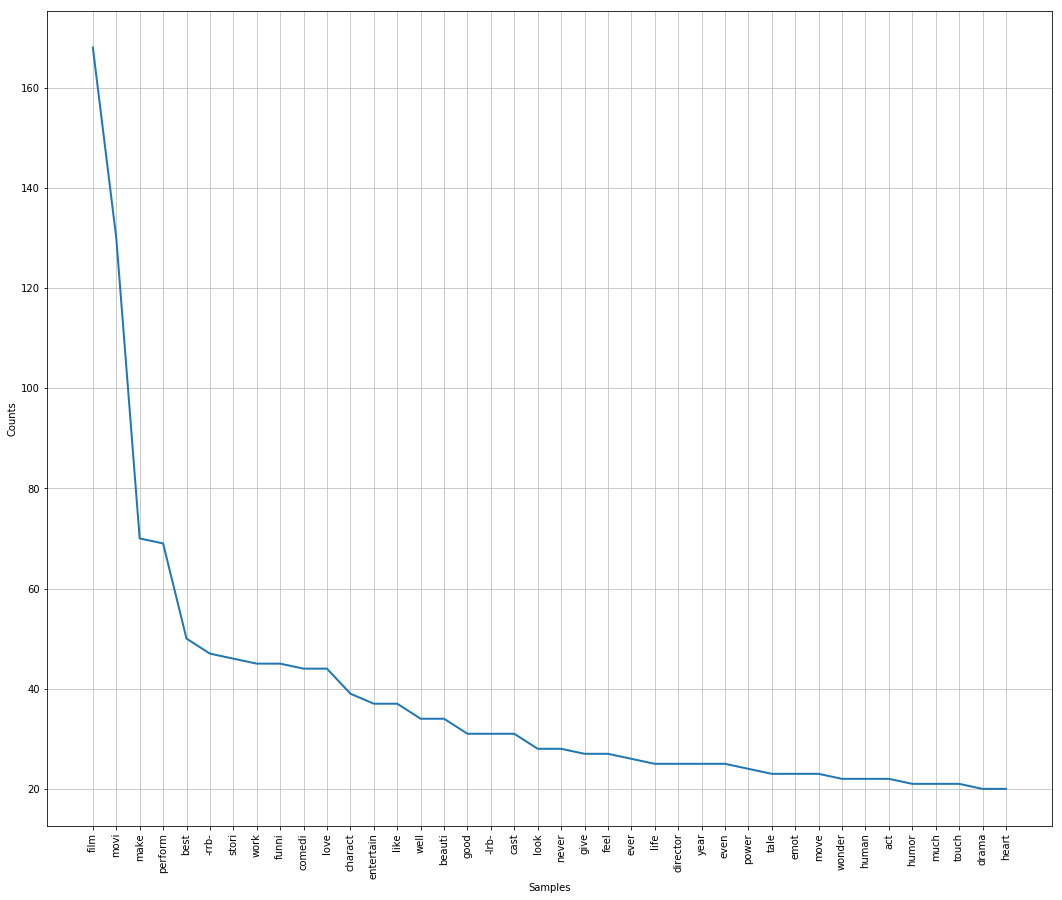

In [518]:
get_freq_dist(wrds5)

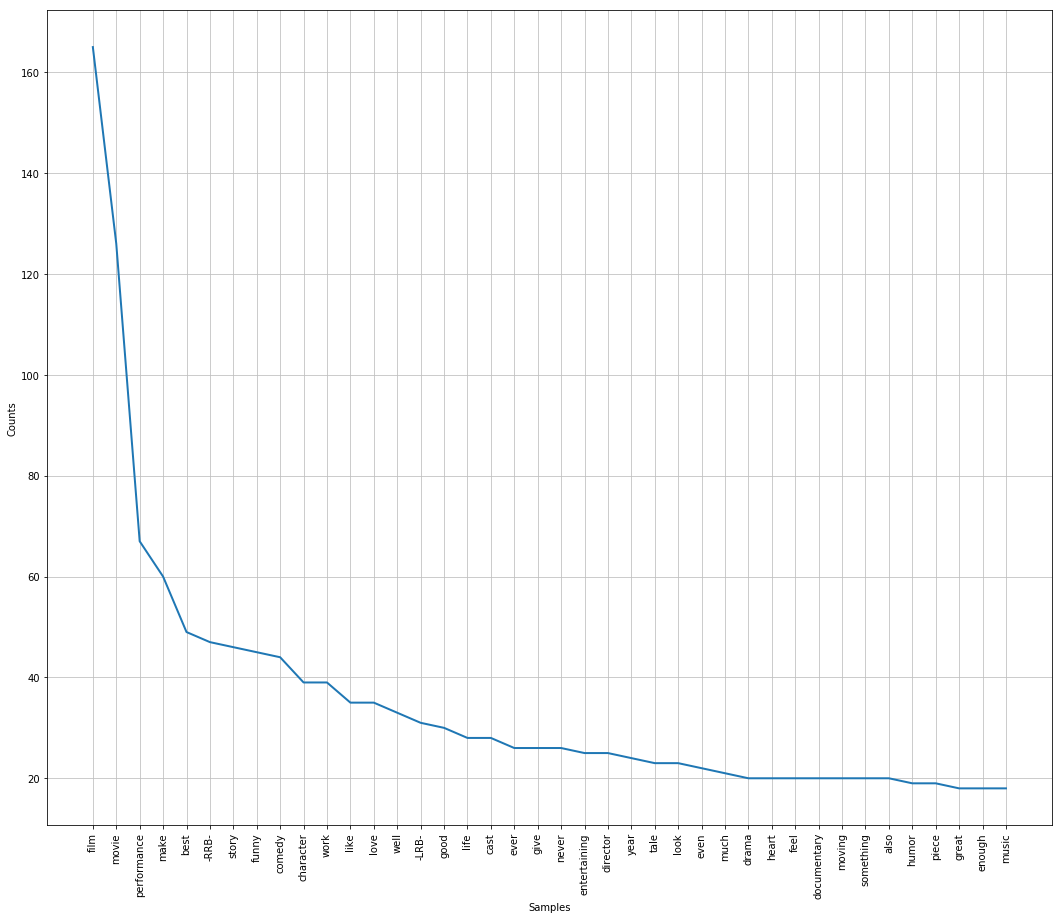

In [519]:
get_freq_dist(wrds6)

The above  2 graphs are of rating 4 and greater than 4. Here e can see that the word goood is accuring less number of times than previous rating (2 to 3) but here we have "words like best,love like" which are occuring more number of times than previous rating, so in this case also the words seem to be realted to raiting and by analysing the counts of words with postive impacts i.e. like,love, best we can say that rating should be higher in this case asame is reflecting in rating too. 

# Extracting festure from cleaned reviews

For extracting features we can use several algorithms and so here i have used all important and algorithms like Bag of Words,TFIDF,Word2Vec and Doc2Vec to find which is the best algorithm out of these. 

In [922]:
def get_bag_of_words(filtered_data,fname):
    vectorize=CountVectorizer(max_df=0.90,max_features=1000,stop_words='english')
    bow=vectorize.fit_transform(filtered_data)
    pickle.dump(vectorize.vocabulary_,open(fname,"wb"))
    return bow

In [923]:
bow_stem=get_bag_of_words(df['Filt_revstm'],'bag_of_words_stem.pkl')

In [924]:
bow_lem=get_bag_of_words(df['Filt_revlem'],'bag_of_words_lem.pkl')

In [523]:
print(bow_stem.shape)
print(bow_lem.shape)

(8504, 1000)
(8504, 1000)


# Using TFIDF for feature extraction

In [927]:
def get_tfidf_data(input_data,fname):
    tfvec=TfidfVectorizer(max_df=0.9,min_df=0.0,max_features=1000,stop_words='english')
    tfidfdt=tfvec.fit_transform(input_data)
    pickle.dump(tfvec.vocabulary_,open(fname,"wb"))
    return tfidfdt

In [928]:
tfwords_stem=get_tfidf_data(df['Filt_revstm'],'TFIDF_stem.pkl')
tfwords_lem=get_tfidf_data(df['Filt_revlem'],'TFIDF_lem.pkl')

In [526]:
#print(tfwords_lem)

In [527]:

Results_index=['Decison_Tree_With_Stem_Bag_words','Decison_Tree_With_lem_Bag_words','Decison_Tree_With_stem_TFIDF','Decison_Tree_With_Lem_TFIDF','Decison_Tree_With_stem_Word2vec','Decison_Tree_With_Lem_Word2vec','Decison_Tree_With_stem_Doc2vec','Decison_Tree_With_Lem_Doc2vec','Naive_bayes_With_stem_Bag_words','Naive_bayes_With_lem_Bag_words','Naive_bayes_With_stem_TFIDF','Naive_bayes_With_lem_TFIDF','XGboost_With_Stem_Bag_words','XGboost_With_lem_Bag_words','XGboost_With_stem_TFIDF','XGboost_With_Lem_TFIDF','XGboost_With_stem_Word2vec','XGboost_With_Lem_Word2vec','XGboost_With_stem_Doc2vec','XGboost_With_Lem_Doc2vec','Random_Forest_With_Stem_Bag_words','Random_Forest_With_lem_Bag_words','Random_Forest_With_stem_TFIDF','Random_Forest_With_Lem_TFIDF','Random_Forest_With_stem_Word2vec','Random_Forest_With_Lem_Word2vec','Random_Forest_With_stem_Doc2vec','Random_Forest_With_Lem_Doc2vec']

In [528]:
Results_columns=['Accuracy','Recall','Precision','F1_Score','Model_FileName']

In [529]:
df_Results=pd.DataFrame(index=Results_index,columns=Results_columns)

In [530]:
df_Results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, Decison_Tree_With_Stem_Bag_words to Random_Forest_With_Lem_Doc2vec
Data columns (total 5 columns):
Accuracy          0 non-null object
Recall            0 non-null object
Precision         0 non-null object
F1_Score          0 non-null object
Model_FileName    0 non-null object
dtypes: object(5)
memory usage: 1.3+ KB


# Using word2vec to get the features 

In [531]:
def save_models(modelname,filename):
    filename=filename+'.sav'
    #print(filename)
    pickle.dump(modelname,open(filename,'wb'))
    return filename

    

In [532]:
def get_model(filename):
    model=pickle.load(open(filename,'rb'))
    return model

In [533]:
def get_word2vec_data(input_dfs):
    tok_words=input_dfs.apply(lambda x:x.split())
    model_word2vec=gensim.models.Word2Vec(tok_words,size=200,window=5,min_count=2,sg=1,hs=0,negative=10,workers=2,seed=34)
    model_word2vec.train(input_dfs,total_examples=len(input_dfs),epochs=20)
    return model_word2vec

In [534]:
model_wrd2vec= get_word2vec_data(df['Filt_revstm'])

In [535]:
model_wrd2vec_lem=get_word2vec_data(df['Filt_revlem'])

In [536]:
save_models(model_wrd2vec_lem,'wrd2vec_lem')

'wrd2vec_lem.sav'

In [537]:
save_models(model_wrd2vec,'wrd2vec_stem')

'wrd2vec_stem.sav'

In [538]:
model_wrd2vec.wv.most_similar(positive='movi')

[('look', 0.9983665943145752),
 ('would', 0.9982447624206543),
 ('could', 0.9978386163711548),
 ('thing', 0.9977255463600159),
 ('make', 0.9975593090057373),
 ('think', 0.9975574016571045),
 ('want', 0.997530996799469),
 ('time', 0.9974427223205566),
 ('first', 0.9973139762878418),
 ('still', 0.9973020553588867)]

In [539]:
model_wrd2vec_lem.wv.most_similar(positive='movie')

[('make', 0.9989686012268066),
 ('much', 0.998843252658844),
 ('thing', 0.9987620711326599),
 ('look', 0.9986761808395386),
 ('could', 0.9986460208892822),
 ('would', 0.998613715171814),
 ('minute', 0.9986119270324707),
 ('many', 0.9986016750335693),
 ('really', 0.9985986948013306),
 ('time', 0.9985480308532715)]

# create vectors from the model

In [540]:


def get_tokenized_words(df_dt):
    tokenize_wrds=df_dt.apply(lambda x:x.split())
    return tokenize_wrds

In [541]:
def create_word_vec(tokens,models,size):
    vec=np.zeros(size).reshape((1,size))
    cnt=0
    for wrd in tokens:
        try:
            vec+=models[wrd].reshape((1,size))
            cnt=cnt+1
        except KeyError:
            continue
    if cnt!=0:
        vec=vec/cnt
    return vec
            

In [542]:
def get_word2vec_vec(tokens,models):
    tokenized_word=get_tokenized_words(tokens)
    wrdvec_arrays=np.zeros((len(tokenized_word),200))
    for i in range(len(tokenized_word)):
        try:
            wrdvec_arrays[i,:]=create_word_vec(tokenized_word[i],models,200)
        except KeyError:
            continue
        df_wrdvec=pd.DataFrame(wrdvec_arrays)
    return df_wrdvec

In [543]:
df_w2vec_stm=get_word2vec_vec(df['Filt_revlem'],model_wrd2vec)

C:\Users\abhinav\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [544]:
df_w2vec_lem=get_word2vec_vec(df['Filt_revstm'],model_wrd2vec_lem)

C:\Users\abhinav\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [545]:
df_w2vec_lem.head()

0         1       2         3         4         5         6    \
0 -0.181283  0.050173  0.2844  0.066987 -0.109107  0.096391 -0.183615   
1  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000  0.000000   

        7         8        9      ...          190       191       192  \
0 -0.050185 -0.107839 -0.18173    ...     0.047824 -0.111651  0.063838   
1  0.000000  0.000000  0.00000    ...     0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.00000    ...     0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.00000    ...     0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.00000    ...     0.000000  0.000000  0.000000   

        193      194       195       196       197       198       199  
0  0.057194  0.10802  0.013605 -0.160806 -0.050511 -0.120292  0.140213  
1  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
3  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
4  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  

[5 rows x 200 columns]

# Doc 2  vector

In [546]:
# Create unoque label for tokens

In [547]:
def create_label(rev):
    token_wrds=get_tokenized_words(rev)
    retval=[]
    for i,val in zip(token_wrds.index,token_wrds):
        retval.append(LabeledSentence(val,['rev_'+str(i)]))
    return retval

In [548]:
lebeled_rev_lem=create_label(df['Filt_revlem'])

C:\Users\abhinav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [549]:
lebeled_rev_stm=create_label(df['Filt_revstm'])

C:\Users\abhinav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [550]:
lebeled_rev_stm[:5]

[LabeledSentence(words=['seri', 'escapad', 'demonstr', 'adag', 'good', 'goos', 'also', 'good', 'gander', 'occasion', 'amus', 'none', 'amount', 'much', 'stori'], tags=['rev_0']),
 LabeledSentence(words=['thi', 'quiet', 'introspect', 'entertain', 'independ', 'worth', 'seek'], tags=['rev_63']),
 LabeledSentence(words=['even', 'fan', 'ismail', 'merchant', 'work', 'suspect', 'would', 'hard', 'time', 'sit'], tags=['rev_81']),
 LabeledSentence(words=['posit', 'thrill', 'combin', 'ethnographi', 'intrigu', 'betray', 'deceit', 'murder', 'shakespearean', 'tragedi', 'juici', 'soap', 'opera'], tags=['rev_116']),
 LabeledSentence(words=['aggress', 'self-glorif', 'manipul', 'whitewash'], tags=['rev_156'])]

In [551]:
def get_mod_d2v(input_df):
    model_d2v=gensim.models.Doc2Vec(dm=1,dm_mean=1,size=200,window=5,negative=7,min_count=5,workers=3,alpha=0.1,seed=23)
    model_d2v.build_vocab([i for i in tqdm(input_df)])
    model_d2v.train(input_df,total_examples=len(input_df ),epochs=15)
    return model_d2v

In [552]:
model_d2v_stm=get_mod_d2v(lebeled_rev_lem)

C:\Users\abhinav\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8504/8504 [00:00<00:00, 2128437.83it/s]


In [553]:
model_d2v_lem=get_mod_d2v(lebeled_rev_lem)

C:\Users\abhinav\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8504/8504 [00:00<?, ?it/s]


In [554]:
save_models(model_d2v_stm,'model_d2v_sm')

'model_d2v_sm.sav'

In [555]:
save_models(model_d2v_lem,'model_d2v_lm')

'model_d2v_lm.sav'

In [556]:
df_d2v_stm=get_word2vec_vec(df['Filt_revstm'],model_d2v_stm)

In [557]:
df_d2v_lem=get_word2vec_vec(df['Filt_revlem'],model_d2v_lem)

# Prepare algorithm for regression and classifiaction

In [558]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree, metrics, model_selection, preprocessing
from IPython.display import Image, display
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,BaggingRegressor,RandomForestRegressor
from sklearn.metrics import r2_score

In [559]:
labelln=df['Sentiment']

In [560]:
def get_test_train_data(x,y,rstate,testsize):
    X_train,X_test,y_train,y_test=model_selection.train_test_split(x,y,random_state=rstate,test_size=testsize)
    return X_train,X_test,y_train,y_test

# Logistic  regression with bag of words

In [561]:
X_trainbwm,X_testbwm,y_trainbwm,y_testbwm=get_test_train_data(bow_stem,labelln,42,0.3)

In [562]:

X_trainbwm,X_testbwm,y_trainbwm,y_testbwm=get_test_train_data(bow_lem,labelln,42,0.3)

In [563]:
X_trainbws,X_testbws,y_trainbws,y_testbws=get_test_train_data(bow_lem,labelln,42,0.3)

In [564]:
regressor=LogisticRegression()


In [565]:
reg_bws=regressor.fit(X_trainbws,y_trainbws)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [566]:
fnrgbws=save_models(reg_bws,'reg_bws')

In [567]:
model_rgbws=get_model(fnrgbws)

In [568]:
y_preds=model_rgbws.predict(X_testbws)

In [569]:
y_preds

array([1, 1, 1, ..., 0, 2, 3], dtype=int64)

In [570]:


r2_score(y_testbws, y_preds,multioutput='variance_weighted')

-0.1259856270440185

In [571]:
metrics.explained_variance_score(y_testbws, y_preds)

-0.12455594808438719

In [572]:
reg_wbm=regressor.fit(X_trainbwm,y_trainbwm)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [573]:
fnrgbwn=save_models(reg_wbm,'reg_wbm')

In [574]:
model_rgwbm=get_model(fnrgbwn)

In [575]:
y_predm=model_rgwbm.predict(X_testbwm)

In [576]:
#y_predm=regressor.predict(X_testbwm)

In [577]:

metrics.mean_squared_error(y_testbwm, y_predm)

1.8295454545454546

In [578]:
metrics.explained_variance_score(y_testbwm, y_predm)

-0.12455594808438719

# Logistic regression with TFIDF

In [579]:
X_traintfs,X_testtfs,y_traintfs,y_testtfs=get_test_train_data(tfwords_stem,labelln,10,0.3)

In [580]:
reg_tfs=regressor.fit(X_traintfs,y_traintfs)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [581]:
fnrgtfs=save_models(reg_tfs,'reg_tfs')

In [582]:
model_rgtfs=get_model(fnrgtfs)

In [583]:
y_predtfs=model_rgtfs.predict(X_testtfs)

In [584]:
#y_predtfs=regressor.predict(X_testtfs)

In [585]:
metrics.mean_absolute_error(y_testtfs, y_predtfs)

0.9502351097178683

In [586]:
X_traintfm,X_testtfm,y_traintfm,y_testtfm=get_test_train_data(tfwords_lem,labelln,10,0.3)

In [587]:
rg_tfm=regressor.fit(X_traintfm,y_traintfm)


C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [588]:
fnrgtfm=save_models(rg_tfm,'rg_tfm')

In [589]:
model_rgtfm=get_model(fnrgtfm)

In [590]:
y_predtfm=model_rgtfm.predict(X_testtfm)

In [591]:
#y_predtfm=regressor.predict(X_testtfm)

In [592]:
y_predtfm

array([3, 1, 1, ..., 3, 1, 3], dtype=int64)

In [593]:
metrics.mean_absolute_error(y_testtfm, y_predtfm)

0.9721786833855799

# Logistic regression with Word 2 Vec


In [594]:
df_w2vec_stm.shape

(8504, 200)

In [595]:
regressor3=LogisticRegression()

In [596]:
#y_trainbwm,y_testbwm

In [597]:
X_trainwvs,X_testwvs,y_trainwvs,y_testwvs=get_test_train_data(df_w2vec_stm,labelln,10,0.3)

In [598]:
rg_wvs=regressor3.fit(X_trainwvs,y_trainwvs)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [599]:
fn_rgwvs=save_models(rg_wvs,'rg_wvs')

In [600]:
model_rgwvs=get_model(fn_rgwvs)

In [601]:
y_predwvs=model_rgwvs.predict(X_testwvs)

In [602]:
#y_predwvs=regressor3.predict(X_testwvs)
y_predwvs

array([3, 3, 3, ..., 3, 3, 1], dtype=int64)

In [603]:
metrics.mean_absolute_error(y_testwvs, y_predwvs)

1.2452978056426331

In [604]:
X_trainwvm,X_testwvm,y_trainwvm,y_testwvm=get_test_train_data(df_w2vec_lem,labelln,10,0.3)

In [605]:
rg_wvm=regressor3.fit(X_trainwvm,y_trainwvm)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [606]:
fnrgwvm=save_models(rg_wvm,'rg_wvm')

In [607]:
model_rgwvm=get_model(fnrgwvm)

In [608]:
y_predwvm=model_rgwvm.predict(X_testwvm)

In [609]:
#y_predwvm=regressor3.predict(X_testwvm)

In [610]:
metrics.mean_absolute_error(y_testwvm, y_predwvm)

1.2468652037617556

# For classifiers lets create three classes Bad and Good based on ratings

In [611]:
df['Rating_class']=df['Sentiment'].apply(lambda x: 'Good' if float(x)>=3 else 'Bad' )

In [612]:
dfreuslt=pd.DataFrame()
dfreuslt.columns=[]

In [613]:
def get_acc_scores(y_test,y_pred):
    acc_score =metrics.accuracy_score(y_test,y_pred)
    cm=confusion_matrix(y_test,y_pred)
    rc=(cm[0,0])/(cm[0,0]+cm[0,1])
    pr=(cm[0,0])/(cm[0,0]+cm[1,0])
    f1_score=2*((pr*rc)/(pr+rc))
    print('Accuracy Score= ',acc_score)
    print('-'*50)
    print('Confusion Matrix= ')
    print(cm)
    print('-'*50)
    print('Recall= ',rc)
    print('-'*50)
    print('Precision= ',pr)
    print('-'*50)
    print('F1 Score= ',f1_score)
    return acc_score,cm,rc,pr,f1_score

In [614]:
df['Rating_class'].unique()

array(['Bad', 'Good'], dtype=object)

# Decision tree with Bagwords and stemmed data

In [615]:
X_traindtbw,X_testdtbw,y_traindtbw,y_testdtbw=get_test_train_data(bow_lem,df['Rating_class'],10,0.3)

In [616]:
dtree1=tree.DecisionTreeClassifier(criterion='entropy',max_depth=20,random_state=0)
dt_bwm=dtree1.fit(X_traindtbw,y_traindtbw)

In [617]:
fndtbwm=save_models(dt_bwm,'dt_bwm')

In [618]:
model_dtbwm=get_model(fndtbwm)

In [619]:
pred_dt_lem=model_dtbwm.predict(X_testdtbw)

In [620]:
#pred_dt_lem=dtree1.predict(X_testdtbw)

In [621]:
pred_dt_lem

array(['Bad', 'Bad', 'Bad', ..., 'Bad', 'Bad', 'Good'], dtype=object)

In [622]:
acc_score_dtbwlm,cm_dtbwlm,rc_dtbwlm,pr_dtbwlm,f1_score_dtbwlm=get_acc_scores(y_testdtbw,pred_dt_lem)

Accuracy Score=  0.6257836990595611
--------------------------------------------------
Confusion Matrix= 
[[1358  116]
 [ 839  239]]
--------------------------------------------------
Recall=  0.921302578018996
--------------------------------------------------
Precision=  0.6181156121984525
--------------------------------------------------
F1 Score=  0.7398529011168619


In [623]:
df_Results['Accuracy']['Decison_Tree_With_lem_Bag_words']=acc_score_dtbwlm*100
df_Results['Recall']['Decison_Tree_With_lem_Bag_words']=rc_dtbwlm*100
df_Results['Precision']['Decison_Tree_With_lem_Bag_words']=pr_dtbwlm*100
df_Results['F1_Score']['Decison_Tree_With_lem_Bag_words']=f1_score_dtbwlm*100
df_Results['Model_FileName']['Decison_Tree_With_lem_Bag_words']=fndtbwm 

In [624]:
df_Results.head()

Accuracy   Recall Precision F1_Score  \
Decison_Tree_With_Stem_Bag_words      NaN      NaN       NaN      NaN   
Decison_Tree_With_lem_Bag_words   62.5784  92.1303   61.8116  73.9853   
Decison_Tree_With_stem_TFIDF          NaN      NaN       NaN      NaN   
Decison_Tree_With_Lem_TFIDF           NaN      NaN       NaN      NaN   
Decison_Tree_With_stem_Word2vec       NaN      NaN       NaN      NaN   

                                 Model_FileName  
Decison_Tree_With_Stem_Bag_words            NaN  
Decison_Tree_With_lem_Bag_words      dt_bwm.sav  
Decison_Tree_With_stem_TFIDF                NaN  
Decison_Tree_With_Lem_TFIDF                 NaN  
Decison_Tree_With_stem_Word2vec             NaN

In [625]:
X_traindtbws,X_testdtbws,y_traindtbws,y_testdtbws=get_test_train_data(bow_stem,df['Rating_class'],10,0.3)

In [626]:
dtree2=tree.DecisionTreeClassifier(criterion='entropy',max_depth=20,random_state=0)
dt_bws=dtree2.fit(X_traindtbws,y_traindtbws)

In [627]:
fndtbws=save_models(dt_bws,'dt_bws')

In [628]:
model_dtwbs=get_model(fndtbws)

In [629]:
pred_dt_stem=model_dtwbs.predict(X_testdtbws)

In [630]:
#pred_dt_stem=dtree2.predict(X_testdtbws)

In [631]:
acc_score_dtbwsm,cm_dtbwsm,rc_dtbwsm,pr_dtbwsm,f1_score_dtbwsm=get_acc_scores(y_testdtbws,pred_dt_stem)

Accuracy Score=  0.6347962382445141
--------------------------------------------------
Confusion Matrix= 
[[1358  116]
 [ 816  262]]
--------------------------------------------------
Recall=  0.921302578018996
--------------------------------------------------
Precision=  0.624655013799448
--------------------------------------------------
F1 Score=  0.744517543859649


In [632]:
df_Results.index

Index(['Decison_Tree_With_Stem_Bag_words', 'Decison_Tree_With_lem_Bag_words',
       'Decison_Tree_With_stem_TFIDF', 'Decison_Tree_With_Lem_TFIDF',
       'Decison_Tree_With_stem_Word2vec', 'Decison_Tree_With_Lem_Word2vec',
       'Decison_Tree_With_stem_Doc2vec', 'Decison_Tree_With_Lem_Doc2vec',
       'Naive_bayes_With_stem_Bag_words', 'Naive_bayes_With_lem_Bag_words',
       'Naive_bayes_With_stem_TFIDF', 'Naive_bayes_With_lem_TFIDF',
       'XGboost_With_Stem_Bag_words', 'XGboost_With_lem_Bag_words',
       'XGboost_With_stem_TFIDF', 'XGboost_With_Lem_TFIDF',
       'XGboost_With_stem_Word2vec', 'XGboost_With_Lem_Word2vec',
       'XGboost_With_stem_Doc2vec', 'XGboost_With_Lem_Doc2vec',
       'Random_Forest_With_Stem_Bag_words', 'Random_Forest_With_lem_Bag_words',
       'Random_Forest_With_stem_TFIDF', 'Random_Forest_With_Lem_TFIDF',
       'Random_Forest_With_stem_Word2vec', 'Random_Forest_With_Lem_Word2vec',
       'Random_Forest_With_stem_Doc2vec', 'Random_Forest_With_Lem_Doc2

In [633]:
df_Results['Accuracy']['Decison_Tree_With_Stem_Bag_words']=acc_score_dtbwsm*100
df_Results['Recall']['Decison_Tree_With_Stem_Bag_words']=rc_dtbwsm*100
df_Results['Precision']['Decison_Tree_With_Stem_Bag_words']=pr_dtbwsm*100
df_Results['F1_Score']['Decison_Tree_With_Stem_Bag_words']=f1_score_dtbwsm*100
df_Results['Model_FileName']['Decison_Tree_With_Stem_Bag_words']=fndtbws

In [634]:
df_Results.head()

Accuracy   Recall Precision F1_Score  \
Decison_Tree_With_Stem_Bag_words  63.4796  92.1303   62.4655  74.4518   
Decison_Tree_With_lem_Bag_words   62.5784  92.1303   61.8116  73.9853   
Decison_Tree_With_stem_TFIDF          NaN      NaN       NaN      NaN   
Decison_Tree_With_Lem_TFIDF           NaN      NaN       NaN      NaN   
Decison_Tree_With_stem_Word2vec       NaN      NaN       NaN      NaN   

                                 Model_FileName  
Decison_Tree_With_Stem_Bag_words     dt_bws.sav  
Decison_Tree_With_lem_Bag_words      dt_bwm.sav  
Decison_Tree_With_stem_TFIDF                NaN  
Decison_Tree_With_Lem_TFIDF                 NaN  
Decison_Tree_With_stem_Word2vec             NaN

In [635]:
tfwords_stem=get_tfidf_data(df['Filt_revstm'])
tfwords_lem=get_tfidf_data(df['Filt_revlem'])

In [636]:
X_traindttfs,X_testdttfs,y_traindttfs,y_testdttfs=get_test_train_data(tfwords_stem,df['Rating_class'],10,0.3)

In [637]:
dtree3=tree.DecisionTreeClassifier(criterion='entropy',max_depth=9,random_state=0)
dt_tfs=dtree3.fit(X_traindttfs,y_traindttfs)

In [638]:
fndttfs=save_models(dt_tfs,'dt_tfs')

In [639]:
model_dttfs=get_model(fndttfs)

In [640]:
pred_tf_sm=model_dttfs.predict(X_testdttfs)

In [641]:
#pred_tf_sm=dtree3.predict(X_testdttfs)

In [642]:
acc_score_dttfsm,cm_dttfsm,rc_dttfsm,pr_dttfsm,f1_score_dttfsm=get_acc_scores(y_testdttfs,pred_tf_sm)

Accuracy Score=  0.6038401253918495
--------------------------------------------------
Confusion Matrix= 
[[1432   42]
 [ 969  109]]
--------------------------------------------------
Recall=  0.9715061058344641
--------------------------------------------------
Precision=  0.5964181591003749
--------------------------------------------------
F1 Score=  0.7390967741935484


In [643]:
df_Results['Accuracy']['Decison_Tree_With_stem_TFIDF']=acc_score_dttfsm*100
df_Results['Recall']['Decison_Tree_With_stem_TFIDF']=rc_dttfsm*100
df_Results['Precision']['Decison_Tree_With_stem_TFIDF']=pr_dttfsm*100
df_Results['F1_Score']['Decison_Tree_With_stem_TFIDF']=f1_score_dttfsm*100
df_Results['Model_FileName']['Decison_Tree_With_stem_TFIDF']=fndttfs
#df_Results.head()

In [644]:
X_traindttfm,X_testdttfm,y_traindttfm,y_testdttfm=get_test_train_data(tfwords_lem,df['Rating_class'],0,0.3)

In [645]:
dtree4=tree.DecisionTreeClassifier(criterion='entropy',max_depth=9,random_state=0)
dt_tfm=dtree4.fit(X_traindttfm,y_traindttfm)

In [646]:
fndttfm=save_models(dt_tfm,'dt_tfm')

In [647]:
model_dttfm=get_model(fndttfm)

In [648]:
pred_tf_lm=model_dttfm.predict(X_testdttfm)

In [649]:
#pred_tf_lm=dtree4.predict(X_testdttfm)

In [650]:
acc_score_dttflm,cm_dttflm,rc_dttflm,pr_dttflm,f1_score_dttflm=get_acc_scores(y_testdttfm,pred_tf_lm)

Accuracy Score=  0.5975705329153606
--------------------------------------------------
Confusion Matrix= 
[[1383   93]
 [ 934  142]]
--------------------------------------------------
Recall=  0.9369918699186992
--------------------------------------------------
Precision=  0.5968925334484246
--------------------------------------------------
F1 Score=  0.7292380701291854


In [651]:
df_Results['Accuracy']['Decison_Tree_With_Lem_TFIDF']=acc_score_dttflm*100
df_Results['Recall']['Decison_Tree_With_Lem_TFIDF']=rc_dttflm*100
df_Results['Precision']['Decison_Tree_With_Lem_TFIDF']=pr_dttflm*100
df_Results['F1_Score']['Decison_Tree_With_Lem_TFIDF']=f1_score_dttflm*100
df_Results['Model_FileName']['Decison_Tree_With_Lem_TFIDF']=fndttfm
#df_Results.head()

In [652]:
df_w2vec_stm=get_word2vec_vec(df['Filt_revlem'],model_wrd2vec)

C:\Users\abhinav\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [653]:
df_w2vec_lem=get_word2vec_vec(df['Filt_revstm'],model_wrd2vec_lem)

C:\Users\abhinav\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [654]:
X_traindtwvs,X_testdtwvs,y_traindtwvs,y_testdtwvs=get_test_train_data(df_w2vec_stm,df['Rating_class'],10,0.3)

In [655]:
dtree5=tree.DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)
dt_wvs=dtree5.fit(X_traindtwvs,y_traindtwvs)

In [656]:
fnwvwbs=save_models(dt_wvs,'dt_wvs')

In [657]:
model_dtwvs=get_model(fnwvwbs)

In [658]:
pred_wv_stm=model_dtwvs.predict(X_testdtwvs)

In [659]:
#pred_wv_stm=dtree5.predict(X_testdtwvs)

In [660]:
acc_score_dtwvsm,cm_dtwvsm,rc_dtwvsm,pr_dtwvsm,f1_score_dtwvsm=get_acc_scores(y_testdtwvs,pred_wv_stm)

Accuracy Score=  0.5768025078369906
--------------------------------------------------
Confusion Matrix= 
[[1458   16]
 [1064   14]]
--------------------------------------------------
Recall=  0.989145183175034
--------------------------------------------------
Precision=  0.578112609040444
--------------------------------------------------
F1 Score=  0.7297297297297297


In [661]:
df_Results['Accuracy']['Decison_Tree_With_stem_Word2vec']=acc_score_dtwvsm*100
df_Results['Recall']['Decison_Tree_With_stem_Word2vec']=rc_dtwvsm*100
df_Results['Precision']['Decison_Tree_With_stem_Word2vec']=pr_dtwvsm*100
df_Results['F1_Score']['Decison_Tree_With_stem_Word2vec']=f1_score_dtwvsm*100
df_Results['Model_FileName']['Decison_Tree_With_stem_Word2vec']=fnwvwbs
#df_Results.head()

In [662]:
X_traindtwvm,X_testdtwvm,y_traindtwvm,y_testdtwvm=get_test_train_data(df_w2vec_lem,df['Rating_class'],10,0.3)

In [663]:
dtree6=tree.DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)
dt_wvm=dtree6.fit(X_traindtwvm,y_traindtwvm)

In [664]:
fndtwvm=save_models(dt_wvm,'dt_wvm')

In [665]:
model_wvm=get_model(fndtwvm)

In [666]:
pred_wv_lm=model_wvm.predict(X_testdtwvm)

In [667]:
#pred_wv_lm=dtree6.predict(X_testdtwvm)

In [668]:
acc_score_dtwvlm,cm_dtwvlm,rc_dtwvlm,pr_dtwvlm,f1_score_dtwvlm=get_acc_scores(y_testdtwvm,pred_wv_lm)

Accuracy Score=  0.5736677115987461
--------------------------------------------------
Confusion Matrix= 
[[1459   15]
 [1073    5]]
--------------------------------------------------
Recall=  0.9898236092265943
--------------------------------------------------
Precision=  0.5762243285939969
--------------------------------------------------
F1 Score=  0.728407388916625


In [669]:
df_Results['Accuracy']['Decison_Tree_With_Lem_Word2vec']=acc_score_dtwvlm*100
df_Results['Recall']['Decison_Tree_With_Lem_Word2vec']=rc_dtwvlm*100
df_Results['Precision']['Decison_Tree_With_Lem_Word2vec']=pr_dtwvlm*100
df_Results['F1_Score']['Decison_Tree_With_Lem_Word2vec']=f1_score_dtwvlm*100
df_Results['Model_FileName']['Decison_Tree_With_Lem_Word2vec']=fndtwvm
#df_Results

In [670]:
X_traindtdvs,X_testdtdvs,y_traindtdvs,y_testdtdvs=get_test_train_data(df_d2v_stm,df['Rating_class'],10,0.3)

In [671]:
dtree7=tree.DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)
dt_dvs=dtree7.fit(X_traindtdvs,y_traindtdvs)

In [672]:
fndtdvs=save_models(dt_dvs,'dt_dvs')

In [673]:
model_dtdvs=get_model(fndtdvs)

In [674]:
pred_dvdt_sm=model_dtdvs.predict(X_testdtdvs)

In [675]:
#pred_dvdt_sm=dtree7.predict(X_testdtdvs)

In [676]:
acc_score_dtdvsm,cm_dtdvsm,rc_dtdvsm,pr_dtdvsm,f1_score_dtdvsm=get_acc_scores(y_testdtdvs,pred_dvdt_sm)

Accuracy Score=  0.5787617554858934
--------------------------------------------------
Confusion Matrix= 
[[1463   11]
 [1064   14]]
--------------------------------------------------
Recall=  0.9925373134328358
--------------------------------------------------
Precision=  0.5789473684210527
--------------------------------------------------
F1 Score=  0.7313171707073232


In [677]:
df_Results['Accuracy']['Decison_Tree_With_stem_Doc2vec']=acc_score_dtdvsm*100
df_Results['Recall']['Decison_Tree_With_stem_Doc2vec']=rc_dtdvsm*100
df_Results['Precision']['Decison_Tree_With_stem_Doc2vec']=pr_dtdvsm*100
df_Results['F1_Score']['Decison_Tree_With_stem_Doc2vec']=f1_score_dtdvsm*100
df_Results['Model_FileName']['Decison_Tree_With_stem_Doc2vec']=fndtdvs
#df_Results

In [678]:
X_traindtdvm,X_testdtdvm,y_traindtdvm,y_testdtdvm=get_test_train_data(df_d2v_lem,df['Rating_class'],0,0.3)

In [679]:
dtree8=tree.DecisionTreeClassifier(criterion='entropy',max_depth=7,random_state=0)
dt_dvm=dtree8.fit(X_traindtdvm,y_traindtdvm)

In [680]:
fndtdvm=save_models(dt_dvm,'dt_dvm')

In [681]:
model_dtdvm=get_model(fndtdvm)

In [682]:
pred_dtwv_lm=model_dtdvm.predict(X_testdtdvm)

In [683]:
#pred_dtwv_lm=dtree8.predict(X_testdtdvm)

In [684]:
acc_score_dtdvlm,cm_dtdvlm,rc_dtdvlm,pr_dtdvlm,f1_score_dtdvlm=get_acc_scores(y_testdtdvm,pred_dtwv_lm)

Accuracy Score=  0.5768025078369906
--------------------------------------------------
Confusion Matrix= 
[[1462   14]
 [1066   10]]
--------------------------------------------------
Recall=  0.9905149051490515
--------------------------------------------------
Precision=  0.5783227848101266
--------------------------------------------------
F1 Score=  0.7302697302697302


In [685]:
df_Results['Accuracy']['Decison_Tree_With_Lem_Doc2vec']=acc_score_dtdvlm*100
df_Results['Recall']['Decison_Tree_With_Lem_Doc2vec']=rc_dtdvlm*100
df_Results['Precision']['Decison_Tree_With_Lem_Doc2vec']=pr_dtdvlm*100
df_Results['F1_Score']['Decison_Tree_With_Lem_Doc2vec']=f1_score_dtdvlm*100
df_Results['Model_FileName']['Decison_Tree_With_Lem_Doc2vec']=fndtdvm
#df_Results

# Using Naive bayes classifiers

# With Bag of Words

In [686]:
from sklearn import naive_bayes

In [687]:
nvmn1=naive_bayes.MultinomialNB()

In [688]:
X_trainnvbws,X_testnvnvbws,y_traindtnvbws,y_testdtnvbws=get_test_train_data(bow_stem,df['Rating_class'],6,0.3)

In [689]:
nv_bws=nvmn1.fit(X_trainnvbws,y_traindtnvbws)

In [690]:
fnnvwbs=save_models(nv_bws,'nv_bws')

In [691]:
model_nvbws=get_model(fnnvwbs)

In [692]:
pred_nvwbs=model_nvbws.predict(X_testnvnvbws)

In [693]:
#pred_nvwbs=nvmn1.predict(X_testnvnvbws)

In [694]:
acc_score_nvbws,cm_nvbws,rc_nvbws,pr_nvbws,f1_score_nvbws=get_acc_scores(y_testdtnvbws,pred_nvwbs)

Accuracy Score=  0.7394200626959248
--------------------------------------------------
Confusion Matrix= 
[[1191  272]
 [ 393  696]]
--------------------------------------------------
Recall=  0.8140806561859193
--------------------------------------------------
Precision=  0.7518939393939394
--------------------------------------------------
F1 Score=  0.7817525434853955


In [695]:
df_Results['Accuracy']['Naive_bayes_With_stem_Bag_words']=acc_score_nvbws*100
df_Results['Recall']['Naive_bayes_With_stem_Bag_words']=rc_nvbws*100
df_Results['Precision']['Naive_bayes_With_stem_Bag_words']=pr_nvbws*100
df_Results['F1_Score']['Naive_bayes_With_stem_Bag_words']=f1_score_nvbws*100
df_Results['Model_FileName']['Naive_bayes_With_stem_Bag_words']=fnnvwbs
#df_Results

In [696]:
X_trainnvbwm,X_testnvbwm,y_trainnvbwm,y_testnvbwm=get_test_train_data(bow_lem,df['Rating_class'],6,0.3)

In [697]:
nvmn2=naive_bayes.MultinomialNB()

In [698]:
nv_bwm=nvmn2.fit(X_trainnvbwm,y_trainnvbwm)

In [699]:
fnnvbwm=save_models(nv_bwm,'nv_bwm')

In [700]:
model_nvbwm=get_model(fnnvbwm)

In [701]:
pred_nv_wbm=model_nvbwm.predict(X_testnvbwm)

In [702]:
#pred_nv_wbm=nvmn2.predict(X_testnvbwm)

In [703]:
acc_score_nvbwm,cm_nvbwm,rc_nvbwm,pr_nvbwm,f1_score_nvbwm=get_acc_scores(y_testnvbwm,pred_nv_wbm)

Accuracy Score=  0.7307993730407524
--------------------------------------------------
Confusion Matrix= 
[[1193  270]
 [ 417  672]]
--------------------------------------------------
Recall=  0.8154477101845523
--------------------------------------------------
Precision=  0.7409937888198758
--------------------------------------------------
F1 Score=  0.7764399609502115


In [704]:
df_Results['Accuracy']['Naive_bayes_With_lem_Bag_words']=acc_score_nvbwm*100
df_Results['Recall']['Naive_bayes_With_lem_Bag_words']=rc_nvbwm*100
df_Results['Precision']['Naive_bayes_With_lem_Bag_words']=pr_nvbwm*100
df_Results['F1_Score']['Naive_bayes_With_lem_Bag_words']=f1_score_nvbwm*100
df_Results['Model_FileName']['Naive_bayes_With_lem_Bag_words']=fnnvbwm
#df_Results

# With TFIDF

In [705]:
X_trainnvtfs,X_testnvtfs,y_trainnvtfs,y_testnvtfs=get_test_train_data(tfwords_stem,df['Rating_class'],6,0.3)

In [706]:
nvmn3=naive_bayes.MultinomialNB()

In [707]:
nv_tfs=nvmn3.fit(X_trainnvtfs,y_trainnvtfs)

In [708]:
fnnvtfs=save_models(nv_tfs,'nv_tfs')

In [709]:
model_nvtfs=get_model(fnnvtfs)

In [710]:
pred_nv_tfs=model_nvtfs.predict(X_testnvtfs)

In [711]:
pred_nv_tfs=nvmn3.predict(X_testnvtfs)

In [712]:
acc_score_nvtfs,cm_nvtfs,rc_nvtfs,pr_nvtfs,f1_score_nvtfs=get_acc_scores(y_testnvtfs,pred_nv_tfs)

Accuracy Score=  0.7276645768025078
--------------------------------------------------
Confusion Matrix= 
[[1262  201]
 [ 494  595]]
--------------------------------------------------
Recall=  0.8626110731373889
--------------------------------------------------
Precision=  0.7186788154897494
--------------------------------------------------
F1 Score=  0.7840944392668531


In [713]:
df_Results['Accuracy']['Naive_bayes_With_stem_TFIDF']=acc_score_nvtfs*100
df_Results['Recall']['Naive_bayes_With_stem_TFIDF']=rc_nvtfs*100
df_Results['Precision']['Naive_bayes_With_stem_TFIDF']=pr_nvtfs*100
df_Results['F1_Score']['Naive_bayes_With_stem_TFIDF']=f1_score_nvtfs*100
df_Results['Model_FileName']['Naive_bayes_With_stem_TFIDF']=fnnvtfs
#df_Results

In [714]:
X_trainnvtfm,X_testnvtfm,y_trainnvtfm,y_testnvtfm=get_test_train_data(tfwords_lem,df['Rating_class'],6,0.3)

In [715]:
nvmn4=naive_bayes.MultinomialNB()

In [716]:
nv_tfm=nvmn4.fit(X_trainnvtfm,y_trainnvtfm)

In [717]:
fnnvtfm=save_models(nv_tfm,'nv_tfm')

In [718]:
model_nvtfm=get_model(fnnvtfm)

In [719]:
pred_nv_tfm=model_nvtfm.predict(X_testnvtfm)

In [720]:
#pred_nv_tfm=nvmn4.predict(X_testnvtfm)

In [721]:
acc_score_nvtfm,cm_nvtfm,rc_nvtfm,pr_nvtfm,f1_score_nvtfm=get_acc_scores(y_testnvtfm,pred_nv_tfm)

Accuracy Score=  0.7268808777429467
--------------------------------------------------
Confusion Matrix= 
[[1255  208]
 [ 489  600]]
--------------------------------------------------
Recall=  0.8578263841421736
--------------------------------------------------
Precision=  0.7196100917431193
--------------------------------------------------
F1 Score=  0.7826629248518865


In [722]:
df_Results['Accuracy']['Naive_bayes_With_lem_TFIDF']=acc_score_nvtfm*100
df_Results['Recall']['Naive_bayes_With_lem_TFIDF']=rc_nvtfm*100
df_Results['Precision']['Naive_bayes_With_lem_TFIDF']=pr_nvtfm*100
df_Results['F1_Score']['Naive_bayes_With_lem_TFIDF']=f1_score_nvtfm*100
df_Results['Model_FileName']['Naive_bayes_With_lem_TFIDF']=fnnvtfm
#df_Results

# Using XGBoost

In [723]:
X_trainxgbws,X_testxgbws,y_trainxgbws,y_testxgbws=get_test_train_data(bow_stem,df['Rating_class'],6,0.3)

In [724]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 17,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 5
}

In [725]:
bst1 = XGBClassifier(**params).fit(X_trainxgbws,y_trainxgbws)

In [726]:
fnbswbs=save_models(bst1,'bst1')

In [727]:
model_bsbws=get_model(fnbswbs)

In [728]:
pred_xgbw_lem=model_bsbws.predict(X_testxgbws)

In [729]:
#pred_xgbw_lem=bst1.predict(X_testxgbws)

In [730]:
acc_score_xgbws,cm_xgbws,rc_xgbws,pr_xgbws,f1_score_xgbws=get_acc_scores(y_testxgbws,pred_xgbw_lem)

Accuracy Score=  0.6845611285266457
--------------------------------------------------
Confusion Matrix= 
[[1228  235]
 [ 570  519]]
--------------------------------------------------
Recall=  0.8393711551606289
--------------------------------------------------
Precision=  0.6829810901001112
--------------------------------------------------
F1 Score=  0.7531432076050292


In [731]:
df_Results['Accuracy']['XGboost_With_Stem_Bag_words']=acc_score_xgbws*100
df_Results['Recall']['XGboost_With_Stem_Bag_words']=rc_xgbws*100
df_Results['Precision']['XGboost_With_Stem_Bag_words']=pr_xgbws*100
df_Results['F1_Score']['XGboost_With_Stem_Bag_words']=f1_score_xgbws*100
df_Results['Model_FileName']['XGboost_With_Stem_Bag_words']=fnbswbs
#df_Results

In [732]:
X_trainxgbwm,X_testxgbwm,y_trainxgbwm,y_testxgbwm=get_test_train_data(bow_lem,df['Rating_class'],10,0.3)

In [733]:
bst2=XGBClassifier(**params).fit(X_trainxgbwm,y_trainxgbwm)

In [734]:
fnbswm=save_models(bst2,'bst2')

In [735]:
model_bswbm=get_model(fnbswm)

In [736]:
pred_xgbm_lm=model_bswbm.predict(X_testxgbwm)

In [737]:
#pred_xgbm_lm=bst2.predict(X_testxgbwm)

In [738]:
acc_score_xgbwm,cm_xgbwm,rc_xgbwm,pr_xgbwm,f1_score_xgbwm=get_acc_scores(y_testxgbwm,pred_xgbm_lm)

Accuracy Score=  0.6622257053291536
--------------------------------------------------
Confusion Matrix= 
[[1225  249]
 [ 613  465]]
--------------------------------------------------
Recall=  0.8310719131614654
--------------------------------------------------
Precision=  0.6664853101196954
--------------------------------------------------
F1 Score=  0.7397342995169084


In [739]:
df_Results['Accuracy']['XGboost_With_lem_Bag_words']=acc_score_xgbwm*100
df_Results['Recall']['XGboost_With_lem_Bag_words']=rc_xgbwm*100
df_Results['Precision']['XGboost_With_lem_Bag_words']=pr_xgbwm*100
df_Results['F1_Score']['XGboost_With_lem_Bag_words']=f1_score_xgbwm*100
df_Results['Model_FileName']['XGboost_With_lem_Bag_words']=fnbswm
#df_Results

In [740]:
X_trainxgtfs,X_testxgtfs,y_trainxgtfs,y_testxgtfs=get_test_train_data(tfwords_stem,df['Rating_class'],10,0.3)

In [741]:
bst3=XGBClassifier(**params).fit(X_trainxgtfs,y_trainxgtfs)

In [742]:
fnbstfs=save_models(bst3,'bst3')

In [743]:
model_bstfs=get_model(fnbstfs)

In [744]:
pred_xgtf_sm=model_bstfs.predict(X_testxgtfs)

In [745]:
#pred_xgtf_sm=bst3.predict(X_testxgtfs)

In [746]:
acc_score_xgtfs,cm_xgtfs,rc_xgtfs,pr_xgtfs,f1_score_xgtfs=get_acc_scores(y_testxgtfs,pred_xgtf_sm)

Accuracy Score=  0.6665360501567398
--------------------------------------------------
Confusion Matrix= 
[[1225  249]
 [ 602  476]]
--------------------------------------------------
Recall=  0.8310719131614654
--------------------------------------------------
Precision=  0.6704980842911877
--------------------------------------------------
F1 Score=  0.7421993335352922


In [747]:
df_Results['Accuracy']['XGboost_With_stem_TFIDF']=acc_score_xgtfs*100
df_Results['Recall']['XGboost_With_stem_TFIDF']=rc_xgtfs*100
df_Results['Precision']['XGboost_With_stem_TFIDF']=pr_xgtfs*100
df_Results['F1_Score']['XGboost_With_stem_TFIDF']=f1_score_xgtfs*100
df_Results['Model_FileName']['XGboost_With_stem_TFIDF']=fnbstfs
#df_Results

In [748]:
X_trainxgtfm,X_testxgtfm,y_trainxgtfm,y_testxgtfm=get_test_train_data(tfwords_lem,df['Rating_class'],10,0.3)

In [749]:
bst4=XGBClassifier(**params).fit(X_trainxgtfm,y_trainxgtfm)

In [750]:
fnbstfm=save_models(bst4,'bst4')

In [751]:
model_bstfm=get_model(fnbstfm)

In [752]:
pred_xgtf_lm=model_bstfm.predict(X_testxgtfm)

In [753]:
#pred_xgtf_lm=bst3.predict(X_testxgtfm)

In [754]:
acc_score_xgtfm,cm_xgtfm,rc_xgtfm,pr_xgtfm,f1_score_xgtfm=get_acc_scores(y_testxgtfm,pred_xgtf_lm)

Accuracy Score=  0.6469435736677116
--------------------------------------------------
Confusion Matrix= 
[[1215  259]
 [ 642  436]]
--------------------------------------------------
Recall=  0.8242876526458616
--------------------------------------------------
Precision=  0.654281098546042
--------------------------------------------------
F1 Score=  0.7295106574602223


In [755]:
df_Results['Accuracy']['XGboost_With_Lem_TFIDF']=acc_score_xgtfm*100
df_Results['Recall']['XGboost_With_Lem_TFIDF']=rc_xgtfm*100
df_Results['Precision']['XGboost_With_Lem_TFIDF']=pr_xgtfm*100
df_Results['F1_Score']['XGboost_With_Lem_TFIDF']=f1_score_xgtfm*100
df_Results['Model_FileName']['XGboost_With_Lem_TFIDF']=fnbstfm

#df_Results

In [756]:
X_trainxgwvs,X_testxgwvs,y_trainxgwvs,y_testxgwvs=get_test_train_data(df_w2vec_stm,df['Rating_class'],0,0.3)

In [757]:
bst5=XGBClassifier(**params).fit(X_trainxgwvs,y_trainxgwvs)

In [758]:
fnbstwvs=save_models(bst5,'bst5')

In [759]:
model_bstwvs=get_model(fnbstwvs)

In [760]:
pred_xgwv_sm=model_bstwvs.predict(X_testxgwvs)

In [761]:
#pred_xgwv_sm=bst5.predict(X_testxgwvs)

In [762]:
acc_score_xgwvs,cm_xgwvs,rc_xgwvs,pr_xgwvs,f1_score_xgwvs=get_acc_scores(y_testxgwvs,pred_xgwv_sm)

Accuracy Score=  0.575626959247649
--------------------------------------------------
Confusion Matrix= 
[[1451   25]
 [1058   18]]
--------------------------------------------------
Recall=  0.9830623306233063
--------------------------------------------------
Precision=  0.5783180550019928
--------------------------------------------------
F1 Score=  0.7282308657465496


In [763]:


df_Results['Accuracy']['XGboost_With_stem_Word2vec']=acc_score_xgtfm*100
df_Results['Recall']['XGboost_With_stem_Word2vec']=rc_xgtfm*100
df_Results['Precision']['XGboost_With_stem_Word2vec']=pr_xgtfm*100
df_Results['F1_Score']['XGboost_With_stem_Word2vec']=f1_score_xgtfm*100
df_Results['Model_FileName']['XGboost_With_stem_Word2vec']=fnbstwvs
#df_Results

In [764]:
params = {
    'objective': 'binary:logistic',
    'max_depth':10,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 5
}

In [765]:
X_trainxgwvm,X_testxgwvm,y_trainxgwvm,y_testxgwvm=get_test_train_data(df_w2vec_lem,df['Rating_class'],0,0.3)

In [766]:
dst6=XGBClassifier(**params).fit(X_trainxgwvm,y_trainxgwvm)

In [767]:
fndstwvm=save_models(dst6,'dst6')

In [768]:
model_bstwvm=get_model(fndstwvm)

In [769]:
pred_xgm_lm=model_bstwvm.predict(X_testxgwvm)

In [770]:
#pred_xgm_lm=dst6.predict(X_testxgwvm)

In [771]:
acc_score_xgwvm,cm_xgwvm,rc_xgwvm,pr_xgwvm,f1_score_xgwvm=get_acc_scores(y_testxgwvm,pred_xgm_lm)

Accuracy Score=  0.5744514106583072
--------------------------------------------------
Confusion Matrix= 
[[1449   27]
 [1059   17]]
--------------------------------------------------
Recall=  0.9817073170731707
--------------------------------------------------
Precision=  0.5777511961722488
--------------------------------------------------
F1 Score=  0.7274096385542169


In [772]:
df_Results['Accuracy']['XGboost_With_Lem_Word2vec']=acc_score_xgwvm*100
df_Results['Recall']['XGboost_With_Lem_Word2vec']=rc_xgwvm*100
df_Results['Precision']['XGboost_With_Lem_Word2vec']=pr_xgwvm*100
df_Results['F1_Score']['XGboost_With_Lem_Word2vec']=f1_score_xgwvm*100
df_Results['Model_FileName']['XGboost_With_Lem_Word2vec']=fndstwvm
#df_Results

In [773]:
X_trainxgdvs,X_testxgdvs,y_trainxgdvs,y_testxgdvs=get_test_train_data(df_d2v_stm,df['Rating_class'],10,0.3)

In [774]:
dst7=XGBClassifier(**params).fit(X_trainxgdvs,y_trainxgdvs)

In [775]:
fnbstdvs=save_models(dst7,'dst7')

In [776]:
model_bstdvs=get_model(fnbstdvs)

In [777]:
pred_xgdv_sm=model_bstdvs.predict(X_testxgdvs)

In [778]:
#pred_xgdv_sm=dst7.predict(X_testxgdvs)

In [779]:
acc_score_xgdvs,cm_xgdvs,rc_xgdvs,pr_xgdvs,f1_score_xgdvs=get_acc_scores(y_testxgdvs,pred_xgdv_sm)

Accuracy Score=  0.5736677115987461
--------------------------------------------------
Confusion Matrix= 
[[1450   24]
 [1064   14]]
--------------------------------------------------
Recall=  0.9837177747625508
--------------------------------------------------
Precision=  0.5767700875099443
--------------------------------------------------
F1 Score=  0.7271815446339016


In [780]:
df_Results['Accuracy']['XGboost_With_stem_Doc2vec']=acc_score_xgdvs*100
df_Results['Recall']['XGboost_With_stem_Doc2vec']=rc_xgdvs*100
df_Results['Precision']['XGboost_With_stem_Doc2vec']=pr_xgdvs*100
df_Results['F1_Score']['XGboost_With_stem_Doc2vec']=f1_score_xgdvs*100
df_Results['Model_FileName']['XGboost_With_stem_Doc2vec']=fnbstdvs
#df_Results

In [781]:
X_trainxgdvm,X_testxgdvm,y_trainxgdvm,y_testxgdvm=get_test_train_data(df_d2v_lem,df['Rating_class'],10,0.3)

In [782]:
dst8=XGBClassifier(**params).fit(X_trainxgdvm,y_trainxgdvm)

In [783]:
fnbstdvm=save_models(dst8,'dst8')

In [784]:
model_bstdvm=get_model(fnbstdvm)

In [785]:
pred_xgdv_lm=model_bstdvm.predict(X_testxgdvm)

In [786]:
#pred_xgdv_lm=dst8.predict(X_testxgdvm)

In [787]:
acc_score_xgdvm,cm_xgdvm,rc_xgdvm,pr_xgdvm,f1_score_xgdvm=get_acc_scores(y_testxgdvm,pred_xgdv_lm)

Accuracy Score=  0.575626959247649
--------------------------------------------------
Confusion Matrix= 
[[1456   18]
 [1065   13]]
--------------------------------------------------
Recall=  0.9877883310719131
--------------------------------------------------
Precision=  0.5775485918286394
--------------------------------------------------
F1 Score=  0.7289111389236546


In [788]:
df_Results['Accuracy']['XGboost_With_Lem_Doc2vec']=acc_score_xgdvm*100
df_Results['Recall']['XGboost_With_Lem_Doc2vec']=rc_xgdvm*100
df_Results['Precision']['XGboost_With_Lem_Doc2vec']=pr_xgdvm*100
df_Results['F1_Score']['XGboost_With_Lem_Doc2vec']=f1_score_xgdvm*100
df_Results['Model_FileName']['XGboost_With_Lem_Doc2vec']=fnbstdvm
#df_Results

# Using Random Forest

In [789]:
X_trainrfbws,X_testxrfbws,y_trainxrfbws,y_testrfbws=get_test_train_data(bow_stem,df['Rating_class'],0,0.3)

In [790]:
rft1=RandomForestClassifier(max_features=6,random_state=1)

In [791]:
rft_wbs=rft1.fit(X_trainrfbws,y_trainxrfbws)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [792]:
fnrfwbs=save_models(rft_wbs,'rft_wbs')

In [793]:
model_rfwbs=get_model(fnrfwbs)

In [794]:
pred_rfbw_sm=model_rfwbs.predict(X_testxrfbws)

In [795]:
#pred_rfbw_sm=rft1.predict(X_testxrfbws)

In [796]:
acc_score_rfbws,cm_rfbws,rc_rfbws,pr_rfbws,f1_score_rfbws=get_acc_scores(y_testrfbws,pred_rfbw_sm)

Accuracy Score=  0.6716300940438872
--------------------------------------------------
Confusion Matrix= 
[[1203  273]
 [ 565  511]]
--------------------------------------------------
Recall=  0.8150406504065041
--------------------------------------------------
Precision=  0.6804298642533937
--------------------------------------------------
F1 Score=  0.7416769420468556


In [797]:
df_Results['Accuracy']['Random_Forest_With_Stem_Bag_words']=acc_score_rfbws*100
df_Results['Recall']['Random_Forest_With_Stem_Bag_words']=rc_rfbws*100
df_Results['Precision']['Random_Forest_With_Stem_Bag_words']=pr_rfbws*100
df_Results['F1_Score']['Random_Forest_With_Stem_Bag_words']=f1_score_rfbws*100
df_Results['Model_FileName']['Random_Forest_With_Stem_Bag_words']=fnrfwbs
#df_Results

In [798]:
X_trainrfbwm,X_testxrfbwm,y_trainxrfbwm,y_testrfbwm=get_test_train_data(bow_lem,df['Rating_class'],0,0.3)

In [799]:
rft2=RandomForestClassifier(max_features=6,random_state=1)

In [800]:
rft_wbm=rft2.fit(X_trainrfbwm,y_trainxrfbwm)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [801]:
fnrfwbm=save_models(rft_wbm,'rft_wbm')

In [802]:
model_rfwbm=get_model(fnrfwbm)

In [803]:
pred_rfbg_lm=model_rfwbm.predict(X_testxrfbwm)

In [804]:
#pred_rfbg_lm=rft2.=predict(X_testxrfbwm)

In [805]:
acc_score_rfbwm,cm_rfbwm,rc_rfbwm,pr_rfbwm,f1_score_rfbwm=get_acc_scores(y_testrfbwm,pred_rfbg_lm)

Accuracy Score=  0.6347962382445141
--------------------------------------------------
Confusion Matrix= 
[[1152  324]
 [ 608  468]]
--------------------------------------------------
Recall=  0.7804878048780488
--------------------------------------------------
Precision=  0.6545454545454545
--------------------------------------------------
F1 Score=  0.7119901112484549


In [806]:
df_Results['Accuracy']['Random_Forest_With_lem_Bag_words']=acc_score_rfbws*100
df_Results['Recall']['Random_Forest_With_lem_Bag_words']=rc_rfbws*100
df_Results['Precision']['Random_Forest_With_lem_Bag_words']=pr_rfbws*100
df_Results['F1_Score']['Random_Forest_With_lem_Bag_words']=f1_score_rfbws*100
df_Results['Model_FileName']['Random_Forest_With_lem_Bag_words']=fnrfwbm
#df_Results

# Using TFIDF

In [807]:
X_trainrftfs,X_testrftfs,y_trainrftfs,y_testrftfs=get_test_train_data(tfwords_stem,df['Rating_class'],10,0.3)

In [808]:
rft3=RandomForestClassifier(max_features=6,random_state=1)

In [809]:
rft_tfs=rft3.fit(X_trainrftfs,y_trainrftfs)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [810]:
fnrftfs=save_models(rft_tfs,'rft_tfs')

In [811]:
model_rftfs=get_model(fnrftfs)

In [812]:
pred_rftf_sm=model_rftfs.predict(X_testrftfs)

In [813]:
#pred_rftf_sm=rft3.predict(X_testrftfs)

In [814]:
acc_score_rftfs,cm_rftfs,rc_rftfs,pr_rftfs,f1_score_rftfs=get_acc_scores(y_testrftfs,pred_rftf_sm)

Accuracy Score=  0.6586990595611285
--------------------------------------------------
Confusion Matrix= 
[[1216  258]
 [ 613  465]]
--------------------------------------------------
Recall=  0.824966078697422
--------------------------------------------------
Precision=  0.6648441771459814
--------------------------------------------------
F1 Score=  0.7363003330305783


In [815]:
df_Results['Accuracy']['Random_Forest_With_stem_TFIDF']=acc_score_rftfs*100
df_Results['Recall']['Random_Forest_With_stem_TFIDF']=rc_rftfs*100
df_Results['Precision']['Random_Forest_With_stem_TFIDF']=pr_rftfs*100
df_Results['F1_Score']['Random_Forest_With_stem_TFIDF']=f1_score_rftfs*100
df_Results['Model_FileName']['Random_Forest_With_stem_TFIDF']=fnrftfs
#df_Results

In [816]:
X_trainrftfm,X_testrftfm,y_trainrftfm,y_testrftfm=get_test_train_data(tfwords_lem,df['Rating_class'],10,0.3)

In [817]:
rft4=RandomForestClassifier(max_features=6,random_state=1)

In [818]:
rft_tfm=rft4.fit(X_trainrftfm,y_trainrftfm)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [819]:
fnrftfm=save_models(rft_tfs,'rft_tfm')

In [820]:
model_rftfs=get_model(fnrftfm)

In [821]:
pred_rftf_lem=model_rftfs.predict(X_testrftfm)

In [822]:
#pred_rftf_lem=rft4.predict(X_testrftfm)

In [823]:
acc_score_rftfm,cm_rftfm,rc_rftfm,pr_rftfm,f1_score_rftfm=get_acc_scores(y_testrftfm,pred_rftf_lem)

Accuracy Score=  0.5450626959247649
--------------------------------------------------
Confusion Matrix= 
[[1056  418]
 [ 743  335]]
--------------------------------------------------
Recall=  0.7164179104477612
--------------------------------------------------
Precision=  0.5869927737632018
--------------------------------------------------
F1 Score=  0.6452795600366635


In [824]:
df_Results['Accuracy']['Random_Forest_With_Lem_TFIDF']=acc_score_rftfm*100
df_Results['Recall']['Random_Forest_With_Lem_TFIDF']=rc_rftfm*100
df_Results['Precision']['Random_Forest_With_Lem_TFIDF']=pr_rftfm*100
df_Results['F1_Score']['Random_Forest_With_Lem_TFIDF']=f1_score_rftfm*100
df_Results['Model_FileName']['Random_Forest_With_Lem_TFIDF']=fnrftfm
#df_Results

# Using Word 2 vec

In [825]:
X_trainrfwvs,X_testrfwvs,y_trainrfwvs,y_testrfwvs=get_test_train_data(df_w2vec_stm,df['Rating_class'],10,0.3)

In [826]:
rft5=RandomForestClassifier(max_features=7,random_state=1)

In [827]:
rft_wvs=rft5.fit(X_trainrfwvs,y_trainrfwvs)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [828]:
fnrfwvs=save_models(rft_wvs,'rft_wvs')

In [829]:
model_rfwvs=get_model(fnrfwvs)

In [830]:
ped_rfwv_sm=model_rfwvs.predict(X_testrfwvs)

In [831]:
#ped_rfwv_sm=rft5.predict(X_testrfwvs)

In [832]:
acc_score_rfwvs,cm_rfwvs,rc_rfwvs,pr_rfwvs,f1_score_rfwvs=get_acc_scores(y_testrfwvs,ped_rfwv_sm)

Accuracy Score=  0.5787617554858934
--------------------------------------------------
Confusion Matrix= 
[[1462   12]
 [1063   15]]
--------------------------------------------------
Recall=  0.9918588873812755
--------------------------------------------------
Precision=  0.579009900990099
--------------------------------------------------
F1 Score=  0.7311827956989247


In [833]:
df_Results['Accuracy']['Random_Forest_With_stem_Word2vec']=acc_score_rfwvs*100
df_Results['Recall']['Random_Forest_With_stem_Word2vec']=rc_rfwvs*100
df_Results['Precision']['Random_Forest_With_stem_Word2vec']=pr_rfwvs*100
df_Results['F1_Score']['Random_Forest_With_stem_Word2vec']=f1_score_rfwvs*100
df_Results['Model_FileName']['Random_Forest_With_stem_Word2vec']=fnrfwvs
#df_Results

In [834]:
X_trainrfwvm,X_testrfwvm,y_trainrfwvm,y_testrfwvm=get_test_train_data(df_w2vec_lem,df['Rating_class'],10,0.3)

In [835]:
rft6=RandomForestClassifier(max_features=7,random_state=1)

In [836]:
rft_wvm=rft6.fit(X_trainrfwvm,y_trainrfwvm)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [837]:
fnrfwvm=save_models(rft_wvm,'rft_wvm')

In [838]:
model_rfwvm=get_model(fnrfwvm)

In [839]:
pred_rfwv_lm=model_rfwvm.predict(X_testrfwvm)

In [840]:
#pred_rfwv_lm=rft6.predict(X_testrfwvm)

In [841]:
acc_score_rfwvm,cm_rfwvm,rc_rfwvm,pr_rfwvm,f1_score_rfwvm=get_acc_scores(y_testrfwvm,pred_rfwv_lm)

Accuracy Score=  0.5783699059561128
--------------------------------------------------
Confusion Matrix= 
[[1463   11]
 [1065   13]]
--------------------------------------------------
Recall=  0.9925373134328358
--------------------------------------------------
Precision=  0.5787183544303798
--------------------------------------------------
F1 Score=  0.7311344327836082


In [842]:
df_Results['Accuracy']['Random_Forest_With_Lem_Word2vec']=acc_score_rfwvm*100
df_Results['Recall']['Random_Forest_With_Lem_Word2vec']=rc_rfwvm*100
df_Results['Precision']['Random_Forest_With_Lem_Word2vec']=pr_rfwvm*100
df_Results['F1_Score']['Random_Forest_With_Lem_Word2vec']=f1_score_rfwvm*100
df_Results['Model_FileName']['Random_Forest_With_Lem_Word2vec']=fnrfwvm
#df_Results

# Using Doc  Vector

In [843]:
X_traintrfdvs,X_testtrfdvs,y_traintrfdvs,y_testrfdvs=get_test_train_data(df_d2v_stm,df['Rating_class'],0,0.3)

In [844]:
rft7=RandomForestClassifier(max_features=9,random_state=1)

In [845]:
rft_dvs=rft7.fit(X_traintrfdvs,y_traintrfdvs)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [846]:
fnrfdvs=save_models(rft_dvs,'rft_dvs')

In [847]:
model_rfdvs=get_model(fnrfdvs)

In [848]:
pred_rfdv_stm=model_rfdvs.predict(X_testtrfdvs)

In [849]:
#pred_rfdv_stm=rft7.predict(X_testtrfdvs)

In [850]:
acc_score_rfdvs,cm_rfdvs,rc_rfdvs,pr_rfdvs,f1_score_rfdvs=get_acc_scores(y_testrfdvs,pred_rfdv_stm)

Accuracy Score=  0.5724921630094044
--------------------------------------------------
Confusion Matrix= 
[[1450   26]
 [1065   11]]
--------------------------------------------------
Recall=  0.9823848238482384
--------------------------------------------------
Precision=  0.5765407554671969
--------------------------------------------------
F1 Score=  0.726634928589326


In [851]:
df_Results['Accuracy']['Random_Forest_With_stem_Doc2vec']=acc_score_rfdvs*100
df_Results['Recall']['Random_Forest_With_stem_Doc2vec']=rc_rfdvs*100
df_Results['Precision']['Random_Forest_With_stem_Doc2vec']=pr_rfdvs*100
df_Results['F1_Score']['Random_Forest_With_stem_Doc2vec']=f1_score_rfdvs*100
df_Results['Model_FileName']['Random_Forest_With_stem_Doc2vec']=fnrfdvs
#df_Results

In [852]:
X_trainrfdvm,X_testrfdvm,y_trainrfdvm,y_testrfdvm=get_test_train_data(df_d2v_lem,df['Rating_class'],0,0.3)

In [853]:
rft8=RandomForestClassifier(max_features=10,random_state=1)

In [854]:
rft_dvm=rft8.fit(X_trainrfdvm,y_trainrfdvm)

C:\Users\abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [855]:
fnrfdvm=save_models(rft_dvm,'rft_dvm')

In [856]:
model_rfdvm=get_model(fnrfdvm)

In [857]:
pred_rfdv_lm=model_rfdvm.predict(X_testrfdvm)

In [858]:
#pred_rfdv_lm=rft8.predict(X_testrfdvm)

In [859]:
acc_score_rfdvm,cm_rfdvm,rc_rfdvm,pr_rfdvm,f1_score_rfdvm=get_acc_scores(y_testrfdvm,pred_rfdv_lm)

Accuracy Score=  0.5740595611285266
--------------------------------------------------
Confusion Matrix= 
[[1458   18]
 [1069    7]]
--------------------------------------------------
Recall=  0.9878048780487805
--------------------------------------------------
Precision=  0.5769687376335576
--------------------------------------------------
F1 Score=  0.7284536597551836


In [860]:
df_Results['Accuracy']['Random_Forest_With_Lem_Doc2vec']=acc_score_rfdvm*100
df_Results['Recall']['Random_Forest_With_Lem_Doc2vec']=rc_rfdvm*100
df_Results['Precision']['Random_Forest_With_Lem_Doc2vec']=pr_rfdvm*100
df_Results['F1_Score']['Random_Forest_With_Lem_Doc2vec']=f1_score_rfdvm*100
df_Results['Model_FileName']['Random_Forest_With_Lem_Doc2vec']=fnrfdvm


# We have built everal models using both Stemmed and Lemmatozed words , e will summarize the accuracy and all other accuracy parameter  to see  which is the best model for the required application

In [861]:
df_Results

Accuracy   Recall Precision F1_Score  \
Decison_Tree_With_Stem_Bag_words   63.4796  92.1303   62.4655  74.4518   
Decison_Tree_With_lem_Bag_words    62.5784  92.1303   61.8116  73.9853   
Decison_Tree_With_stem_TFIDF        60.384  97.1506   59.6418  73.9097   
Decison_Tree_With_Lem_TFIDF        59.7571  93.6992   59.6893  72.9238   
Decison_Tree_With_stem_Word2vec    57.6803  98.9145   57.8113   72.973   
Decison_Tree_With_Lem_Word2vec     57.3668  98.9824   57.6224  72.8407   
Decison_Tree_With_stem_Doc2vec     57.8762  99.2537   57.8947  73.1317   
Decison_Tree_With_Lem_Doc2vec      57.6803  99.0515   57.8323   73.027   
Naive_bayes_With_stem_Bag_words     73.942  81.4081   75.1894  78.1753   
Naive_bayes_With_lem_Bag_words     73.0799  81.5448   74.0994   77.644   
Naive_bayes_With_stem_TFIDF        72.7665  86.2611   71.8679  78.4094   
Naive_bayes_With_lem_TFIDF         72.6881  85.7826    71.961  78.2663   
XGboost_With_Stem_Bag_words        68.4561  83.9371   68.2981  75.3143   
XGboost_With_lem_Bag_words         66.2226  83.1072   66.6485  73.9734   
XGboost_With_stem_TFIDF            66.6536  83.1072   67.0498  74.2199   
XGboost_With_Lem_TFIDF             64.6944  82.4288   65.4281  72.9511   
XGboost_With_stem_Word2vec         64.6944  82.4288   65.4281  72.9511   
XGboost_With_Lem_Word2vec          57.4451  98.1707   57.7751   72.741   
XGboost_With_stem_Doc2vec          57.3668  98.3718    57.677  72.7182   
XGboost_With_Lem_Doc2vec           57.5627  98.7788   57.7549  72.8911   
Random_Forest_With_Stem_Bag_words   67.163  81.5041    68.043  74.1677   
Random_Forest_With_lem_Bag_words    67.163  81.5041    68.043  74.1677   
Random_Forest_With_stem_TFIDF      65.8699  82.4966   66.4844    73.63   
Random_Forest_With_Lem_TFIDF       54.5063  71.6418   58.6993   64.528   
Random_Forest_With_stem_Word2vec   57.8762  99.1859    57.901  73.1183   
Random_Forest_With_Lem_Word2vec     57.837  99.2537   57.8718  73.1134   
Random_Forest_With_stem_Doc2vec    57.2492  98.2385   57.6541  72.6635   
Random_Forest_With_Lem_Doc2vec      57.406  98.7805   57.6969  72.8454   

                                  Model_FileName  
Decison_Tree_With_Stem_Bag_words      dt_bws.sav  
Decison_Tree_With_lem_Bag_words       dt_bwm.sav  
Decison_Tree_With_stem_TFIDF          dt_tfs.sav  
Decison_Tree_With_Lem_TFIDF           dt_tfm.sav  
Decison_Tree_With_stem_Word2vec       dt_wvs.sav  
Decison_Tree_With_Lem_Word2vec        dt_wvm.sav  
Decison_Tree_With_stem_Doc2vec        dt_dvs.sav  
Decison_Tree_With_Lem_Doc2vec         dt_dvm.sav  
Naive_bayes_With_stem_Bag_words       nv_bws.sav  
Naive_bayes_With_lem_Bag_words        nv_bwm.sav  
Naive_bayes_With_stem_TFIDF           nv_tfs.sav  
Naive_bayes_With_lem_TFIDF            nv_tfm.sav  
XGboost_With_Stem_Bag_words             bst1.sav  
XGboost_With_lem_Bag_words              bst2.sav  
XGboost_With_stem_TFIDF                 bst3.sav  
XGboost_With_Lem_TFIDF                  bst4.sav  
XGboost_With_stem_Word2vec              bst5.sav  
XGboost_With_Lem_Word2vec               dst6.sav  
XGboost_With_stem_Doc2vec               dst7.sav  
XGboost_With_Lem_Doc2vec                dst8.sav  
Random_Forest_With_Stem_Bag_words    rft_wbs.sav  
Random_Forest_With_lem_Bag_words     rft_wbm.sav  
Random_Forest_With_stem_TFIDF        rft_tfs.sav  
Random_Forest_With_Lem_TFIDF         rft_tfm.sav  
Random_Forest_With_stem_Word2vec     rft_wvs.sav  
Random_Forest_With_Lem_Word2vec      rft_wvm.sav  
Random_Forest_With_stem_Doc2vec      rft_dvs.sav  
Random_Forest_With_Lem_Doc2vec       rft_dvm.sav

In [862]:
def save_result(df_result):
    df_result.to_csv('df_result.csv',index=True)


In [863]:
save_result(df_Results)

 From above table we can derive that the best classification model is -
 # Naive Bayes #
and best  feature extraction algorthims are
# Bag of words and TFIDF  
In case of stemming and Lemmatization oth have similar accuracy in with Naive Bayes with slight better output with steming. 

We can also say that 
# XGBoost with bag of words and TFIDF
have average and considerable output.

# we will apply the best models to test data

# Preparing test data for model

In [864]:
dftst=pd.read_csv('test.tsv',sep='\t')

In [865]:
dftst.head()

PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine

In [866]:
dftst['SentenceId'].duplicated().any()

True

In [867]:
dftst=drop_duplicates(dftst)

In [868]:
dftst['SentenceId'].duplicated().any()

False

In [869]:
dftst1=remove_stopword(dftst['Phrase'])

In [870]:
dftst2=rem_shortword(dftst1)
dftst2[:10]

0          intermittently pleasing mostly routine effort
15     Kidman really thing worth watching Birthday Gi...
93            Once rhythm movie becomes heady experience
117    kept wishing watching documentary wartime Nava...
158    Kinnear sympathy rather delivers performance s...
189    ends well sort frenzied comic moments never click
211    hoot half great American people candidate like...
263    weight piece unerring professionalism chilly p...
301    film contains good jokes good scenes barely mo...
344    offbeat sometimes gross surprisingly appealing...
Name: Phrase, dtype: object

In [871]:
dftst2=replace_empty_rows(dftst2)

In [872]:
dftst2[:10]

0          intermittently pleasing mostly routine effort
15     Kidman really thing worth watching Birthday Gi...
93            Once rhythm movie becomes heady experience
117    kept wishing watching documentary wartime Nava...
158    Kinnear sympathy rather delivers performance s...
189    ends well sort frenzied comic moments never click
211    hoot half great American people candidate like...
263    weight piece unerring professionalism chilly p...
301    film contains good jokes good scenes barely mo...
344    offbeat sometimes gross surprisingly appealing...
Name: Phrase, dtype: object

# Apply stemming and lemmatization on test data

In [873]:
dftst['Filt_revstm']=dftst2.apply(stem_words)
dftst['Filt_revlem']=dftst1.apply(lem_words)

In [874]:
dftst.isnull().any()

PhraseId       False
SentenceId     False
Phrase         False
Filt_revstm    False
Filt_revlem    False
dtype: bool

In [875]:
dftst.head()

PhraseId  SentenceId                                             Phrase  \
0      156061        8545  An intermittently pleasing but mostly routine ...   
15     156076        8546  Kidman is really the only thing that 's worth ...   
93     156154        8547  Once you get into its rhythm ... the movie bec...   
117    156178        8548  I kept wishing I was watching a documentary ab...   
158    156219        8549  Kinnear does n't aim for our sympathy , but ra...   

                                           Filt_revstm  \
0                 intermitt pleas mostli routin effort   
15   kidman realli thing worth watch birthday girl ...   
93                  onc rhythm movi becom headi experi   
117  kept wish watch documentari wartim navajo acco...   
158  kinnear sympathi rather deliv perform strike s...   

                                           Filt_revlem  
0     An intermittently pleasing mostly routine effort  
15   Kidman really thing 's worth watching Birthday...  
93   Once get rhythm ... movie becomes heady experi...  
117  I kept wishing I watching documentary wartime ...  
158  Kinnear n't aim sympathy rather delivers perfo...

# Apply bag words on test data

In [876]:
bow_test_stem=get_bag_of_words(dftst['Filt_revstm'])
bow_test_lem=get_bag_of_words(dftst['Filt_revstm'])

In [877]:
bow_test_stem

<3310x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16997 stored elements in Compressed Sparse Row format>

# Apply TFIDF on test data

In [878]:
tfwords_test_stem=get_tfidf_data(dftst['Filt_revstm'])
tfwords_test_lem=get_tfidf_data(dftst['Filt_revlem'])

# Apply model to test data

In [879]:
# Get predicted data

In [880]:
def save_pred_data(files,ids,fnames):
    df_filedata=pd.DataFrame()
    df_filedata['Id']=ids
    df_filedata['Pred_Data']=files
    df_filedata.to_csv(fnames,index=False)
    

In [881]:
def get_pred_test_data(model_file,feat_words):
    model_name=get_model(model_file)
    pred_test=model_name.predict(feat_words)
    return pred_test
    

In [882]:
def get_file_names(model,dfs):
    fname=dfs['Model_FileName'][model]
    return fname

# Predicted data for naive bayes using stemmmed words

In [883]:
fname_naive_BagWord_stem=get_file_names('Naive_bayes_With_stem_Bag_words',df_Results)
fname_naive_BagWord_stem

'nv_bws.sav'

In [884]:
pred_test_Naive_BagWord_stem=get_pred_test_data(fname_naive_BagWord_stem,bow_test_stem)

In [885]:
len(pred_test_Naive_BagWord_stem)

3310

In [886]:
save_pred_data(pred_test_Naive_BagWord_stem,dftst['SentenceId'],'pred_nvBagWord_stem_test.csv')


In [887]:
fname_naive_lem_bagwrd=get_file_names('Naive_bayes_With_lem_Bag_words',df_Results)
fname_naive_lem_bagwrd

'nv_bwm.sav'

In [888]:
pred_test_Naive_BagWord_lem=get_pred_test_data(fname_naive_lem_bagwrd,bow_test_lem)
pred_test_Naive_BagWord_lem

array(['Bad', 'Bad', 'Good', ..., 'Bad', 'Bad', 'Bad'], dtype='<U4')

In [889]:
save_pred_data(pred_test_Naive_BagWord_lem,dftst['SentenceId'],'pred_nvBagWord_lem_test.csv')

In [890]:
fname_naive_stem_TFIDF=get_file_names('Naive_bayes_With_stem_TFIDF',df_Results)
fname_naive_stem_TFIDF

'nv_tfs.sav'

In [891]:
pred_test_Naive_stem_TFIDF=get_pred_test_data(fname_naive_stem_TFIDF,tfwords_test_stem)

In [892]:
pred_test_Naive_stem_TFIDF

array(['Good', 'Bad', 'Bad', ..., 'Bad', 'Bad', 'Bad'], dtype='<U4')

In [893]:
save_pred_data(pred_test_Naive_stem_TFIDF,dftst['SentenceId'],'pred_nvTFIDF_stem_test.csv')

In [894]:
fname_naive_lem_TFIDF=get_file_names('Naive_bayes_With_lem_TFIDF',df_Results)
fname_naive_lem_TFIDF

'nv_tfm.sav'

In [895]:
pred_test_Naive_lem_TFIDF=get_pred_test_data(fname_naive_lem_TFIDF,tfwords_test_lem)

In [896]:
pred_test_Naive_lem_TFIDF

array(['Good', 'Good', 'Bad', ..., 'Good', 'Bad', 'Bad'], dtype='<U4')

In [897]:
save_pred_data(pred_test_Naive_lem_TFIDF,dftst['SentenceId'],'pred_nvTFIDF_lem_test.csv')